# Master's Capstone

--> By: James Quacinella <--

# Table of Contents

* [Abstract](#Abstract)
* [Methods](#Methods)
* [Pre-Data Collection](#Pre-Data-Collection)
* [Data Collection](#Data-Collection)
  * [Consumer Expenditure Report](#Consumer-Expenditure-Report)
  * [USDA Food Plans](#USDA-Food-Plans)
  * [Free Market Rent Data From HUD](#Free-Market-Rent-Data-From-HUD)
  * [Medical Expenditure Panel Survey from the AHRQ](#Medical-Expenditure-Panel-Survey-from-the-AHRQ)
  * [Tax Data](#Tax-Data)
* [Model Variables](#Model-Variables)
    * [Housing Costs](#Housing-Costs)
    * [Food Costs](#Food-Costs)
    * [Child Care Cost](#Child-Care-Cost)
    * [Health Insurance Costs](#Health-Insurance-Costs)
    * [Transportation Costs](#Transportation-Cost)
    * [Health Care Costs](#Health-Care-Costs)
    * [Other Necessities Cost](#Other-Necessities-Cost)
    * [Taxes](#Taxes-Data)
      * [Payroll Taxes](#Payroll-Taxes)
      * [State Tax Rate](#State-Tax-Rate)
      * [Federal Income Tax Rate](#Federal-Income-Tax-Rate)
* [Creating Final Merged Data Frame](#Creating-Final-Merged-Data-Frame)
* [Introductory Analysis](#Introductory-Analysis)
  * [Living Wage in Individual Counties](#Living-Wage-in-Individual-Counties)
  * [State Averages of the Living Wage](#State-Averages-of-the-Living-Wage)
  * [Regional Averages of the Living Wage](#Regional-Averages-of-the-Living-Wage)
  * [National Average Breakdown Across 2004 - 2014](#National-Average-Breakdown-Across-2004---2014)
  * [Living Wage Distribution in Most Populous Counties](#Living-Wage-Distribution-in-Most-Populous-Counties)
  * [Living Wage Breakdown by Race](#Living-Wage-Breakdown-by-Race)
* [Living Wage Gap](#Living-Wage-Gap)
* [Correlations with Economic Metrics](#Correlations-with-Economic-Metrics)
* [Appendix](#Appendix---Data-Tables)
  * [Data Tables](#Appendix---Data-Tables)
  * [Things to Revisit](#Appendix---Things-to-Revisit)


# Abstract

**Objectives:** This study will extend an established model for estimating the current living wage in 2014 to the past decade for the purpose of:

* an exploratory analysis trends in the gap between the estimated living wage and the minimum wage
* evaluating any correlation between the living wage gap and other economic metrics, including public funds spent on social services

**Methods:** The original data set for this model is for 2014. This study will extend the data sources of this model into the past to enable trend analysis. Data for economic metrics from public data sources will supplement this data for correlation analysis.


# Methods

## Model

The original model proposed estimated the living wage in terms of 9 variables:

** *basic_needs_budget* ** = *food_cost* + *child_care_cost* + ( *insurance_premiums* + *health_care_costs* ) + *housing_cost* + *transportation_cost* + *other_necessities_cost*

** *living_wage* ** = *basic_needs_budget* + ( *basic_needs_budget* \* *tax_rate* )

## Data Sources

The following data sources are used to find estimates of the model variables:

* The food cost is estimated from data from the USDA’s low-cost food plan national average in June 2014.
* Child care is based off state-level estimates published by the National Association of Child Care Resource and Referral Agencies.
* Insurance costs are based on the insurance component of the 2013 Medical Expenditure Panel Survey.
* Housing costs are estimated from the HUD Fair Market Rents (FMR) estimates
* Other variables are pulled from the 2014 Bureau of Labor Statistics Consumer Expenditure Survey.

These data sets extend into the past, allowing for calculating the model for years past. The data will also have to be adjusted for inflation 6.

## Analytic Approach

First, data will be gathered from the data sources of the original model but will be extended into the past. The methodology followed by the model will be replicated to come up with a data set representing estimates of the living wage across time. After the data set is prepared, the trend of the living wage as compared to minimum wage can be examined. Has the gap increased or decreased over time, and at what rate? Have certain areas seen larger than average increases or decreases in this gap? 

Once preliminary trend analysis is done, this data set will be analyzed in comparison to other economic trends to see if any interesting correlations can be found. Correlations to GDP growth rate and the national rate of unemployment can be made, but the primary investigation will be to see if the living wage gap correlates to national spending on SNAP (Food stamps). In other words, we will see if there is any (potentially time lagged) relationship between the living wage gap and how much the United States needs to spend to support those who cannot make ends meet. A relationship here can potentially indicate that shrinking this gap could lower public expenditures.


## Presentation Of Results

Results will be presented for both parts of the data analysis. For studying the living wage gap trends, this report will present graphs of time series, aggregated in different ways, of the living wage as well as the living wage gap. Some of these time series will be presented along side data on public expenditures on SNAP to visually inspect for correlations.

## Background / Sources

- Glasmeier AK, Nadeau CA, Schultheis E: LIVING WAGE CALCULATOR User’s Guide / Technical Notes 2014 Update
- USDA low-cost food plan, June, 2014
- Child Care in America 2014 State fact sheets
- 2013 Medical Expenditure Panel Survey Available
- Consumer Expenditure Survey
- Inflation Calculator

------

------

------

# Pre-Data Collection

([TOC](#Table-of-Contents))

Lets do all of our imports now:

In [16]:
%pylab inline

# Standard stuff
import os
import itertools
from collections import OrderedDict, defaultdict
import pickle

# Data science!
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

# For crawling insurance data
from bs4 import BeautifulSoup

# Useful for display purposes
from prettytable import PrettyTable
# from IPython.core.display import HTML
from IPython.display import display, HTML
from pprint import pprint

# Used for determining string similarity for county names
# import editdist


# Path to local dir on my laptop
PROJECT_PATH = "/home/james/Development/Masters/Thesis"

def constant_factory(value):
    ''' Always prodcues a constant value; used fo defaultdict '''
    return itertools.repeat(value).next

def caption(msg, tablenum):
    ''' Help convert text into suitable table caption '''
    return "<br><b>Table %d - %s</b>" % (tablenum, msg)

Populating the interactive namespace from numpy and matplotlib


Lets setup some inflation multipliers:

In [4]:
# Multiply a dollar value to get the equivalent 2014 dollars
# Original numbers from model; used to confirm methodology matches the original model
inflation_multipliers = {
    2010: 1.092609, 
    2011: 1.059176,
    2012: 1.037701,
    2013: 1.022721,
    2014: 1.0
}

# Updated inflation numbers should scale to 2015 dollars
updated_inflation_multipliers = {
    2000: 1.3811731,
    2001: 1.3429588,
    2002: 1.3220567,
    2003: 1.2925978,
    2004: 1.2590683,
    2005: 1.2178085,
    2006: 1.179752,
    2007: 1.1470807,
    2008: 1.1046664,
    2009: 1.1086106, 
    2010: 1.0907198, 
    2011: 1.0573444,
    2012: 1.0359069,
    2013: 1.0209524,
    2014: 1.004655
}

Global identifiers used throughout the project:

In [5]:
# Constants used to refer to US regions
REGION_EAST = 'east'
REGION_MIDWEST = 'midwest'
REGION_SOUTH = 'south'
REGION_WEST = 'west'
REGION_BASE = 'base'   # Used for when a state is not in a region (Alaska, Hawaii mostly)

# Create a initial state to region mapping to use for regional weighting
state_to_region_mapping = defaultdict(constant_factory(REGION_BASE))
    
state_to_region_mapping.update(
    { 
    'PA': REGION_EAST, 'NJ': REGION_EAST, 'NY': REGION_EAST, 'CT': REGION_EAST, 'MA': REGION_EAST,
    'NH': REGION_EAST, 'VT': REGION_EAST, 'ME': REGION_EAST, 'RI': REGION_EAST, 
    'OH': REGION_MIDWEST, 'IL': REGION_MIDWEST, 'IN': REGION_MIDWEST, 'WI': REGION_MIDWEST, 'MI': REGION_MIDWEST,
    'MN': REGION_MIDWEST, 'IA': REGION_MIDWEST, 'MO': REGION_MIDWEST, 'KS': REGION_MIDWEST, 'NE': REGION_MIDWEST,
    'SD': REGION_MIDWEST, 'ND': REGION_MIDWEST,
    'TX': REGION_SOUTH, 'OK': REGION_SOUTH, 'AR': REGION_SOUTH, 'LA': REGION_SOUTH, 'MS': REGION_SOUTH,
    'AL': REGION_SOUTH, 'GA': REGION_SOUTH, 'FL': REGION_SOUTH, 'SC': REGION_SOUTH, 'NC': REGION_SOUTH,
    'VA': REGION_SOUTH, 'WV': REGION_SOUTH, 'KY': REGION_SOUTH, 'TN': REGION_SOUTH, 'MD': REGION_SOUTH,
    'DE': REGION_SOUTH,
    'CA': REGION_WEST, 'OR': REGION_WEST, 'WA': REGION_WEST, 'NV': REGION_WEST, 'ID': REGION_WEST,
    'UT': REGION_WEST, 'AZ': REGION_WEST, 'MT': REGION_WEST, 'WY': REGION_WEST, 'CO': REGION_WEST,
    'NM': REGION_WEST, 'AK': REGION_BASE, 'HI': REGION_BASE
})

# Create the inverse mapping of region to list of states
region_to_state_mapping = { }
for state, region in state_to_region_mapping.iteritems():
    if region in region_to_state_mapping:
        region_to_state_mapping[region].append(state)
    else:
        region_to_state_mapping[region] = [state]

# State to full statename mapping
state_to_statename_mapping = {u'AK': u'alaska', u'AL': u'alabama', u'AR': u'arkansas', u'AZ': u'arizona', 
  u'CA': u'california', u'CO': u'colorado', u'CT': u'connecticut', u'DC': u'district of columbia', u'DE': 
  u'delaware', u'FL': u'florida', u'GA': u'georgia', u'HI': u'hawaii', u'IA': u'iowa', u'ID': u'idaho', 
  u'IL': u'illinois', u'IN': u'indiana', u'KS': u'kansas', u'KY': u'kentucky', u'LA': u'louisiana', 
  u'MA': u'massachusetts', u'MD': u'maryland', u'ME': u'maine', u'MI': u'michigan', u'MN': u'minnesota', 
  u'MO': u'missouri', u'MS': u'mississippi', u'MT': u'montana', u'NC': u'north carolina', u'ND': u'north dakota', 
  u'NE': u'nebraska', u'NH': u'new hampshire', u'NJ': u'new jersey', u'NM': u'new mexico', u'NV': u'nevada', 
  u'NY': u'new york', u'OH': u'ohio', u'OK': u'oklahoma', u'OR': u'oregon', u'PA': u'pennsylvania', 
  u'RI': u'rhode island', u'SC': u'south carolina', u'SD': u'south dakota', u'TN': u'tennessee', u'TX': u'texas', 
  u'UT': u'utah', u'VA': u'virginia', u'VT': u'vermont', u'WA': u'washington', u'WI': u'wisconsin', 
  u'WV': u'west virginia', u'WY': u'wyoming'}

Lets setup regional differences for the food data:

In [6]:
# Multiply price of food by regional multipler to get better estimate of food costs
food_regional_multipliers = {
    REGION_EAST: 0.08,
    REGION_WEST: 0.11,
    REGION_SOUTH: -0.07,
    REGION_MIDWEST: -0.05,
}

Create list of values for the years we will work with in the model

In [7]:
model_years = range(2004, 2015)

Some useful FIPS codes:

In [8]:
# FIPS code for NYC Counties Kings 
newyork_county = 3606199999
kings_county = 3604799999
queens_county = 3608199999
bronx_county = 3600599999
richmond_count = 3608599999
nyc_counties = [newyork_county, kings_county, queens_county, bronx_county, richmond_count]

# FIPS code for Trenton, NJ
mercer_county = 3402199999

# Fips code for Orange county
orange_county = 601399999

Global knobs for visuals

In [516]:
global_fontweight = 'bold'
global_fontsize = 20
# global_theme = "whitegrid"
global_theme= "darkgrid"
global_theme_options = {"axes.facecolor": ".9"}

def setup_custom_visuals():
    sns.set_style(global_theme, global_theme_options)

    font = {'weight' : global_fontweight,
            'size'   : global_fontsize}
    tick = {
        'labelsize' : 12  # fontsize of the x any y labels
    }

    rc('font', **font)  # pass in the font dict as kwargs
    rc('xtick', **tick)
    rc('ytick', **tick)
    
def setup_default_visuals():
    rcdefaults()
    sns.set_style(global_theme, global_theme_options)

setup_default_visuals()
setup_custom_visuals()

------

------

------

#  Data Collection 

([TOC](#Table-of-Contents))

The following sections will outline how I gathered the data for the various model parameters as well as other data we need to calculate their values. The original model was made for 2014 data and extending this data to the past means we need to be careful that any changes in the underlying data methodology of these parameters needs to be noted.

## Data Sources

### Consumer Expenditure Report

Wget commands used to get the Consumer Expenditure Reports:

In [ ]:
# Get CEX for 2013 and 2014 (XLSX format)
for i in `seq 2013 2014`; do wget http://www.bls.gov/cex/$i/aggregate/cusize.xlsx -O ${i}_cex.xlsx; done

# Get CEX for 2004 - 2012 (XLS format)
for i in `seq 2004 2012`; do wget http://www.bls.gov/cex/$i/aggregate/cusize.xls -O ${i}_cex.xls; done

# Get CEX for 2001 to 2003 (TXT format)
for i in `seq 2001 2003`; do wget http://www.bls.gov/cex/aggregate/$i/cusize.txt -O ${i}_cex.txt; done


# Get CEX region for 2013 and 2014 (XLSX format)
for i in `seq 2013 2014`; do wget http://www.bls.gov/cex/$i/aggregate/region.xlsx -O ${i}_region_cex.xlsx; done

# Get CEX region for 2004 - 2012 (XLS format)
for i in `seq 2004 2012`; do wget http://www.bls.gov/cex/$i/aggregate/region.xls -O ${i}_region_cex.xls; done

# Get CEX region for 2001 to 2003 (TXT format)
for i in `seq 2001 2003`; do wget http://www.bls.gov/cex/aggregate/$i/region.txt -O ${i}_region_cex.txt; done

### USDA Food Plans

Wget commands used to gather data files:

In [ ]:
# Change command to get '10 - '15
for i in {1..9}; do  wget http://www.cnpp.usda.gov/sites/default/files/usda_food_plans_cost_of_food/CostofFoodJun0$i.pdf; done

### Free Market Rent Data From HUD

Below are the wget commands for getting the FMR data

In [ ]:
cd data/fmr
for i in `seq 2014 2015`; do wget http://www.huduser.gov/portal/datasets/fmr/fmr${i}f/FY${i}_4050_RevFinal.xls -O fmr${i}.xlsx; done
for i in `seq 2010 2013`; do wget http://www.huduser.gov/portal/datasets/fmr/fmr${i}f/FY${i}_4050_Final.xls -O fmr${i}.xlsx; done
for i in `seq 2009 2009`; do wget http://www.huduser.gov/portal/datasets/fmr/fmr${i}r/FY${i}_4050_Rev_Final.xls -O fmr${i}.xlsx; done

# GRRRR
wget http://www.huduser.gov/portal/datasets/fmr/fmr2008r/FMR_county_fy2008r_rdds.xls
wget http://www.huduser.gov/portal/datasets/fmr/fmr2007f/FY2007F_County_Town.xls
wget http://www.huduser.gov/portal/datasets/fmr/fmr2006r/FY2006_County_Town.xls
wget http://www.huduser.gov/portal/datasets/fmr/fmr2005r/Revised_FY2005_CntLevel.xls
wget http://www.huduser.gov/portal/datasets/FMR/FMR2004F/FMR2004F_County.xls
wget http://www.huduser.gov/portal/datasets/fmr/FMR2003F_County.xls
wget http://www.huduser.gov/portal/datasets/fmr/FMR2002F.xls

In [23]:
# Counties dict will map county ID to useful infomation, mostly region and state
counties = { }

### Medical Expenditure Panel Survey from the AHRQ

Below are the wget commands used to download this data. This data will have to be further parsed from HTML.

In [ ]:
# Load insurance data
cd data/insurance
for i in `seq 2001 2014`; do 
    wget -O ${i}_tiic2.html http://meps.ahrq.gov/mepsweb/data_stats/summ_tables/insr/state/series_2/${i}/tiic2.htm ;
done

### Tax Data

Here is all the files we need for tax data:

In [ ]:
# Data from Tax Foundation on individual tax rates per state per year
cd data/taxes
wget -O State_Individual_Income_Tax_Rates_2000-2014.xlsx http://taxfoundation.org/sites/taxfoundation.org/files/docs/State%20Individual%20Income%20Tax%20Rates%2C%202000-2014.xlsx

---

---

---

## Model Variables  

[TOC](#Table-of-Contents)

### Housing Costs

Definition from the model:

> We assumed  that  a  one  adult  family  would  rent a  single occupancy unit (zero bedrooms) for an individual adult household, that a two adult family would  rent a one bedroom apartment,

The counties are identified by the FIPS code, which is just state code + county code + subcounty code (only post 2005). 

We need to do some string matching to find FIPS codes for 2002, since they are not in the file. Exact matches work for 84% of the data. The other data is filled in via finding name with smallest levishtein distance. Used [py-editdist]( http://www.mindrot.org/projects/py-editdist) instead of nltk's implementation due to speed issues.

Final data can be found in the [Appendix: Housing Costs Data Table](#Housing-Costs-Data-Table).

#### Methodology Confidence 

**TODO**

#### TODO

* Fix 2002 issue
* Look into 2005 and 2006 transition


In [657]:
# Fair Market Rent data
fmr_data = { }

def pad_county(county):
    ''' Pad counties to three digits when we need to construct one manually. '''
    return '%03d' % county

def pad_fips(fip):
    ''' Add 99999 to end of fip code (which nullifies the subcounty identifier) '''
    return int(str(fip) + '99999')

# For now, loading 2002 - 2014
for year in range(2002, 2015):
    with open(PROJECT_PATH + "/data/fmr/fmr%d.csv" % year, 'rb') as csvfile:
        # Store dataframe from csv into dict
        fmr_data[year] = pd.read_csv(csvfile)
        
        # Lower case headings to make life easier
        fmr_data[year].columns = map(str.lower, fmr_data[year].columns)
        
        # Custom processing per year
        if year > 2012:
            # Left out "fips2010"
            fmr_data[year] = fmr_data[year][["fmr1", "county", "cousub", "countyname", "fips2000", "pop2010", "state", "state_alpha"]]
            # TODO: should we do this?
            # fmr_data[year]['fips'] = fmr_data[year]['fips2000']
            fmr_data[year].rename(columns={'fips2000':'fips', 'pop2010': 'pop'}, inplace=True)
            fmr_data[year] = fmr_data[year].query('cousub == 99999').reset_index(drop=True)
        elif year > 2005:
            fmr_data[year] = fmr_data[year][["fmr1", "county", "cousub", "countyname", "fips", "pop2000", "state", "state_alpha"]]
            fmr_data[year].rename(columns={'pop2000': 'pop'}, inplace=True)
            fmr_data[year] = fmr_data[year].query('cousub == 99999').reset_index(drop=True)
        elif year == 2005:
            fmr_data[year] = fmr_data[year][["fmr_1bed", "county", "countyname", "pop2000", "state", "state_alpha", "stco"]]
            fmr_data[year].rename(columns={'stco':'fips', 'fmr_1bed': 'fmr1', 'pop2000': 'pop'}, inplace=True)
            fmr_data[year]['fips'] = fmr_data[year]['fips'].map(pad_fips)
        elif year == 2004:
            fmr_data[year] = fmr_data[year][["new_fmr1", "county", "countyname", "pop100", "state", "state_alpha"]]
            fmr_data[year]['fips'] = fmr_data[year]['state'].map(str) + fmr_data[year]['county'].map(pad_county)
            fmr_data[year].rename(columns={'new_fmr1': 'fmr1', 'pop100': 'pop'}, inplace=True)
            fmr_data[year]['fips'] = fmr_data[year]['fips'].map(pad_fips)
        elif year == 2003:
            fmr_data[year] = fmr_data[year][["fmr1", "county", "countyname", "pop", "state", "state_alpha"]]
            fmr_data[year]['fips'] = fmr_data[year]['state'].map(str) + fmr_data[year]['county'].map(pad_county)
            fmr_data[year]['fips'] = fmr_data[year]['fips'].map(pad_fips)
        elif year == 2002:
            # NOTE: we have to calculate FIPS codes by hand in cell below
            fmr_data[year] = fmr_data[year][["fmr1br", "areaname", "st"]]
            fmr_data[year].rename(columns={'st':'state_alpha', 'fmr1br': 'fmr1', 'areaname': 'countyname'}, inplace=True)

        # Inflation
        fmr_data[year]['fmr1_inf'] = fmr_data[year]['fmr1'] * updated_inflation_multipliers[year]
        
        # Add region column
        # METHOD: the defaultdict will use region_base if the state is not in the initial state to region mapping
        fmr_data[year]['region'] = fmr_data[year]['state_alpha'].map(lambda x: state_to_region_mapping[x])

In [243]:
# year = 2004
# f = open(PROJECT_PATH + "/data/fmr/fmr%s.csv" % year, 'rb')
# df = pd.read_csv(f)
# df.columns = map(str.lower, df.columns)
# df = df[["new_fmr1", "county", "countyname", "pop100", "state", "state_alpha"]]

# df['fips'] = df['state'].map(str) + df['county'].map(pad_county)
# df.rename(columns={'new_fmr1': 'fmr1'}, inplace=True)
# df['fips'] = df['fips'].map(pad_fips)
# df[ df['state_alpha'] == 'NH' ]

In [ ]:
# year = 2005
# f = open(PROJECT_PATH + "/data/fmr/fmr%s.csv" % year, 'rb')
# df2 = pd.read_csv(f)
# df2.columns = map(str.lower, df2.columns)

# df2 = df2[["fmr_1bed", "county", "countyname", "pop2000", "state", "state_alpha", "stco"]]
# df2.rename(columns={'stco':'fips', 'fmr_1bed': 'fmr1'}, inplace=True)
# df2['fips'] = df2['fips'].map(pad_fips)

# df2[ df2['state_alpha'] == 'NH' ]
# fmr_data[2005][fmr_data[2005]['state_alpha'] == 'NH']

In [14]:
# set(fmr_data[2005]['state_alpha'].values) - set(fmr_data[2006]['state_alpha'].values)

{'CT', 'MA', 'ME', 'NH', 'RI', 'VT'}

In [342]:
##### Handle 2002 data ######

# Custom comparator to compare column of strings to given string
def compare_lambda(y):
    def compare(x):
        return (x[0], x[1], editdist.distance(x[1], y), x[2])
    return compare

# Init list of fips we need to find and a bitmap of which 2002 counties we processes
fips = [ None ] * len(fmr_data[2002]['countyname'])
found_bitmap = [ False ] * len(fmr_data[2002]['countyname'])

# For each count in 2002 ...
# for idx, countyname in enumerate(fmr_data[2002]['countyname']):
for idx, county_and_state in enumerate(fmr_data[2002][['countyname', 'state_alpha']].values.tolist()):
    (countyname, state) = county_and_state
    
    # See if any row mathes this countyname exactly
    county_matches = fmr_data[2003][ (fmr_data[2003]['state_alpha'] == state) & (fmr_data[2003]['countyname'].str.lower() == countyname.lower()) ]
    
    if len(county_matches) > 0:
        fips_val = county_matches['fips'].values[0]
        found_bitmap[idx] = True
        fips[idx] = fips_val

In [ ]:
##### Handle 2002 data ######

# For each county in 2002 ...
# for idx, countyname in enumerate(fmr_data[2002]['countyname']):
for idx, county_and_state in enumerate(fmr_data[2002][['countyname', 'state_alpha']].values.tolist()):
    (countyname, state) = county_and_state
        
    # If already matched, we skip; otherwise ...
    if not found_bitmap[idx]:
        # Get list of counties (as tuples) in 2003 which we try to match to
        # good_counties = list(enumerate(fmr_data[2003]['countyname']))
        good_counties = list(enumerate([ list(i) for i in fmr_data[2003][ fmr_data[2003]['state_alpha'] == state ][['countyname', 'fips']].values]))

        if len(good_counties) == 0:
            continue
        
        # Get list of distances from 2002 countyname to all 2003 countynames
        # NOTE: use of compare_lambda to create custom comparator that also 
        # returns data in (idx, countyname, levdist) form
        distances = map(compare_lambda(countyname.lower()), 
                        map(lambda x: (x[0], x[1][0].lower(), x[1][1]), 
                            good_counties))
        
        # Find the minimum distance (with custom key to only compare third element, which is levdist)
        min_distance = min(distances, key=lambda x: x[2])

        
        # Update bitmap and store appropriate FIPS code from 2003 
        found_bitmap[idx] = True
        fips[idx] = min_distance[3]
        
# Add calculated fips to new column in 2002
fmr_data[2002]['fips'] = fips

In [658]:
##### Construct final multi-level dataframe #####

fmr_df = pd.DataFrame()
for year in model_years:
    mindex = pd.MultiIndex.from_tuples(zip([year]*len(fmr_data[year]), fmr_data[year]['fips']), names=["year", "fips"])
    new_df = fmr_data[year]
    new_df.index = mindex
    new_df.columns = fmr_data[year].columns
    fmr_df = pd.concat([fmr_df, new_df])

In [248]:
# [ list(i) for i in fmr_data[2003][ fmr_data[2003]['state_alpha'] == 'OR' ][['countyname', 'fips']].values]

# fmr_data[2002][ fmr_data[2002]['state_alpha'] == 'OR' ][['countyname', 'fips']].values

# np.sum(found_bitmap) / float(len(found_bitmap))

# print len(set(fmr_data[2002][ fmr_data[2002]['state_alpha'] == 'NY' ]['fips']))
# print len(set(fmr_data[2003][ fmr_data[2003]['state_alpha'] == 'NY' ]['fips']))

# set(fmr_data[2003][ fmr_data[2003]['state_alpha'] == 'NY' ]['fips']).difference(set(fmr_data[2002][ fmr_data[2002]['state_alpha'] == 'NY' ]['fips']))

## Filter out FIPS that are consistent

Seems like data from 2002 - 2003 is iffy with respect to matching counties; restricting the analysis from 2004 for now, until I can figure out a way to do better mapping

In [14]:
countyset = set(fmr_data[2004]['fips'])
# print len(countyset)

# Create set that is the intersection of all fips values
for year in range(2005, 2014):
    countyset = countyset.intersection(set(fmr_data[year]['fips']))

# Filter out each dataframe based on above set
for year in range(2005, 2014):
    fmr_data[year] = fmr_data[year][ fmr_data[year].isin({'fips': countyset})['fips'].values ]

# Confirm
# print fmr_data[2004].sort('fips')
# print fmr_data[2005].sort('fips')

#### Issue with county change from 2005 to 2006

In [15]:
for year in model_years:
    x = set(fmr_data[year]['fips'])
    y = set(fmr_data[year+1]['fips'])
    print("Diff between %d and %d is: %s" % (year, year+1, len(y.difference(x))))
    print("Diff between %d and %d is: %s" % (year, year+1, len(x.difference(y))))
    print

# print(list(set(fmr_data[2005]['fips']))[0:10])
# print(list(set(fmr_data[2006]['fips']))[0:10])

print set(fmr_data[2006]['fips']).difference(set(fmr_data[2005]['fips']))

Diff between 2004 and 2005 is: 0
Diff between 2004 and 2005 is: 103

Diff between 2005 and 2006 is: 0
Diff between 2005 and 2006 is: 0

Diff between 2006 and 2007 is: 0
Diff between 2006 and 2007 is: 0

Diff between 2007 and 2008 is: 0
Diff between 2007 and 2008 is: 0

Diff between 2008 and 2009 is: 0
Diff between 2008 and 2009 is: 0

Diff between 2009 and 2010 is: 0
Diff between 2009 and 2010 is: 0

Diff between 2010 and 2011 is: 0
Diff between 2010 and 2011 is: 0

Diff between 2011 and 2012 is: 0
Diff between 2011 and 2012 is: 0

Diff between 2012 and 2013 is: 0
Diff between 2012 and 2013 is: 0

Diff between 2013 and 2014 is: 56
Diff between 2013 and 2014 is: 0



KeyError: 2015

### Most Populous Counties

[This article from Business Insider](http://www.businessinsider.com/half-of-the-united-states-lives-in-these-counties-2013-9) lists the top 150 counties by population.

**TODO:** 12 counties are not matches, since these have breakdowns of subcounties. This is similar to the issue with counties in 2004 - 2006

In [13]:
# Taken from link above
most_populous_counties = [("Los Angeles County","CA"),("Cook County", "IL"),("Harris County", "TX"),("Maricopa County", "AZ"),("San Diego County","CA"),("Orange County", "CA"),("Miami-Dade County","FL"),("Kings County", "NY"),("Dallas County", "TX"),("Queens County", "NY"),("Riverside County", "CA"),("San Bernardino County","CA"),("King County", "WA"),("Clark County", "NV"),("Tarrant County", "TX"),("Santa Clara County","CA"),("Broward County", "FL"),("Wayne County", "MI"),("Bexar County", "TX"),("New York County","NY"),("Alameda County", "CA"),("Philadelphia County", "PA"),("Middlesex County", "MA"),("Suffolk County", "NY"),("Sacramento County", "CA"),("Bronx County", "NY"),("Palm Beach County","FL"),("Nassau County", "NY"),("Hillsborough County", "FL"),("Cuyahoga County", "OH"),("Allegheny County", "PA"),("Oakland County", "MI"),("Orange County", "FL"),("Franklin County", "OH"),("Hennepin County", "MN"),("Fairfax County", "VA"),("Travis County", "TX"),("Contra Costa County","CA"),("Salt Lake County","UT"),("Montgomery County", "MD"),("St. Louis County", "MO"),("Pima County", "AZ"),("Fulton County", "GA"),("Honolulu County", "HI"),("Mecklenburg County", "NC"),("Westchester County", "NY"),("Milwaukee County", "WI"),("Wake County", "NC"),("Fresno County", "CA"),("Shelby County", "TN"),("Fairfield County", "CT"),("DuPage County", "IL"),("Pinellas County", "FL"),("Erie County", "NY"),("Marion County", "IN"),("Bergen County", "NJ"),("Hartford County", "CT"),("Prince George's County", "MD"),("Duval County", "FL"),("New Haven County","CT"),("Kern County", "CA"),("Macomb County", "MI"),("Gwinnett County", "GA"),("Ventura County", "CA"),("Collin County", "TX"),("El Paso County","TX"),("San Francisco County","CA"),("Middlesex County", "NJ"),("Baltimore County", "MD"),("Pierce County", "WA"),("Montgomery County", "PA"),("Hidalgo County", "TX"),("Worcester County", "MA"),("Hamilton County", "OH"),("Essex County", "NJ"),("Multnomah County", "OR"),("Essex County", "MA"),("Jefferson County", "KY"),("Monroe County", "NY"),("Suffolk County", "MA"),("Oklahoma County", "OK"),("San Mateo County","CA"),("Snohomish County", "WA"),("Cobb County", "GA"),("Denton County", "TX"),("DeKalb County", "GA"),("San Joaquin County","CA"),("Lake County", "IL"),("Will County", "IL"),("Norfolk County", "MA"),("Jackson County", "MO"),("Bernalillo County", "NM"),("Jefferson County", "AL"),("Hudson County", "NJ"),("Davidson County", "TN"),("Lee County", "FL"),("El Paso County","CO"),("Denver County", "CO"),("District of Columbia","DC"),("Monmouth County", "NJ"),("Providence County", "RI"),("Fort Bend County","TX"),("Bucks County", "PA"),("Baltimore city", "MD"),("Polk County", "FL"),("Kent County", "MI"),("Tulsa County", "OK"),("Arapahoe County", "CO"),("Ocean County", "NJ"),("Delaware County", "PA"),("Johnson County", "KS"),("Bristol County", "MA"),("Anne Arundel County","MD"),("Washington County", "OR"),("Brevard County", "FL"),("New Castle County","DE"),("Jefferson County", "CO"),("Union County", "NJ"),("Summit County", "OH"),("Utah County", "UT"),("Montgomery County", "OH"),("Douglas County", "NE"),("Lancaster County", "PA"),("Kane County", "IL"),("Stanislaus County", "CA"),("Ramsey County", "MN"),("Camden County", "NJ"),("Chester County", "PA"),("Sedgwick County", "KS"),("Dane County", "WI"),("Passaic County", "NJ"),("Guilford County", "NC"),("Plymouth County", "MA"),("Morris County", "NJ"),("Volusia County", "FL"),("Lake County", "IN"),("Sonoma County", "CA"),("Montgomery County", "TX"),("Spokane County", "WA"),("Richmond County", "NY"),("Pasco County", "FL"),("Greenville County", "SC"),("Onondaga County", "NY"),("Hampden County", "MA"),("Adams County", "CO"),("Williamson County", "TX")]

most_populous_fips = []

for (county, state) in most_populous_counties:
    selector = fmr_data[2014][ fmr_data[2014]['state_alpha'] == state ]['countyname'].map(str.lower)  == county.lower()
    if not np.any(selector):
        print "missed %s %s" % (county, state)
    else:
        most_populous_fips.append( fmr_data[2014][ fmr_data[2014]['state_alpha'] == state ][selector]['fips'].values[0] )

len(most_populous_fips)

missed Middlesex County MA
missed Fairfield County CT
missed Hartford County CT
missed New Haven County CT
missed Worcester County MA
missed Essex County MA
missed Suffolk County MA
missed Norfolk County MA
missed Providence County RI
missed Bristol County MA
missed Plymouth County MA
missed Hampden County MA


134

In [30]:
# Serialize
# pickle.dump(most_populous_fips, open(os.path.join(PROJECT_PATH, "data/most_populous_fips.v1.csv"), "wb"))

# De-serialize
most_populous_fips = pickle.load(open(os.path.join(PROJECT_PATH, "data/most_populous_fips.v1.csv"), "rb"))

## Food Costs

([TOC](#Table-of-Contents))
 
Data for the food calculations have been successfully downloaded in PDF form. The main way to calculate this is, from the PDF:

>Adult  food  consumption  costs  are  estimated  by  averaging  the  low - cost  plan  food  costs for  males  and  females  between  19  and  50

Note, we add 20% to the values from the data sheets, since the notes on all published PDFs from the USDA state to add 20% to the listed values for individuals since:

>The costs given are for individuals in 4-person families. For individuals in other size families, the following adjustments are suggested: 1-person—add 20 percent; ...

The notes for the model also state that regional weights are applied to give a better estimate for food costs across the nation. The result of this section are values for 2014 that match exactly to the data given on the model website, so I am confident the implementation of the methodology below is correct.

The final data can be seen in the [Appendix: Food Costs Data Table](#Food-Costs-Data-Table)

### Notes: Change of USDA Methodology

In 2006, the data from the USDA changed the age ranges for their healthy meal cost calculations. The differences in range are minimal and should not effect overall estimations.

### Methodology Confidence

The methodology of this section produces numbers exactly like the original model, so the confidence in the methodology is **high**.

In [671]:
# The base food cost (not regionally weighed) for nation (data pulled manually from PDFs)
national_monthly_food_cost_per_year = {
    2014: {"base": np.average([241.50, 209.80])},
    2013: {"base": np.average([234.60, 203.70])},
    2012: {"base": np.average([234.00, 203.00])},
    2011: {"base": np.average([226.80, 196.90])},
    2010: {"base": np.average([216.30, 187.70])},
    2009: {"base": np.average([216.50, 187.90])},
    2008: {"base": np.average([216.90, 189.60])},
    2007: {"base": np.average([200.20, 174.10])},
    2006: {"base": np.average([189.70, 164.80])},
    2005: {"base": np.average([186.20, 162.10])},
    2004: {"base": np.average([183.10, 159.50])},
    2003: {"base": np.average([174.20, 151.70])},
    2002: {"base": np.average([170.30, 148.60])},
    2001: {"base": np.average([166.80, 145.60])},
}

# Create ordered dict to make sure we process things in order
national_monthly_food_cost_per_year = OrderedDict(sorted(national_monthly_food_cost_per_year.items(), 
                                                        key=lambda t: t[0]))

# Adjust the data according to notes above
for year in national_monthly_food_cost_per_year:
    # Inflation and 20% adjustment
    national_monthly_food_cost_per_year[year]["base"] = \
        national_monthly_food_cost_per_year[year]["base"] * 1.20 * updated_inflation_multipliers[year]

    # Regional adjustment
    for region in food_regional_multipliers:
        national_monthly_food_cost_per_year[year][region] = \
            national_monthly_food_cost_per_year[year]["base"] * (1 + food_regional_multipliers[region])

national_monthly_food_cost_per_year_df = pd.DataFrame.from_dict(national_monthly_food_cost_per_year)

## Child Care Cost

([TOC](#Table-of-Contents))
 
Manually download PDFs from ChildCareAware.org. Sadly, they only go back to 2010. I can now either:

* have to find other estimates of child care costs from pre-2010 (prefered)
* check if the Consumer Expenditure Survey has data on this
* impute the data (dont think this is a good idea)
* limit the analysis going back to 2010 (which seems limiting since other data, like the Consumer Expenditure Survey in 2014 provides 2013 data and that is the latest currently).

Currently I am only focusing on modeling costs for a single adult (an assumption I made early on) since I am interested in trends, and the other 'family configurations' are just linear combinations of the costs for one adult and for one child. However if I wanted to extend the numbers for 1 adult + 1 child, I would have to look into this further. For now I'll move on.

## Health Insurance Costs

([TOC](#Table-of-Contents))
 
The model uses data from the Medical Expenditure Panel Survey from the Agency for Healthcare Research and Quality (searchable [here](http://meps.ahrq.gov/mepsweb/data_stats/quick_tables_search.jsp?component=2&subcomponent=2)). Specifically, the model assumes a single adult's insurance costs are best estimated from Table X.C.1 Employee contribution distributions (in dollars) for private-sector employees enrolled in single coverage. This survey gives the mean cost for a single adult per state. 

Table X.C.1 was only added to the survey starting in 2006. There is an alternative table that appears in all years (Table II.C.2: Average total employee contribution (in dollars) per enrolled employee for single coverage at private-sector establishments), which is what is downloaded from the previous section.

One problem is that in 2007 this survey was not done. I solved this by linearly impute data from 2006 and 2008, which seems resonable if we can assume that costs tend to go up every year and not go down. This is true for the data I have looked at.
    
Another problem is that some states do not appear in the earlier data due to funding issues (and not being able to get a statistically significant sample). I fix this by using the value in the data for 'states not specified' and fill in the missing states.

Below is code on processing each html file.

Final table shown in [Appendix: Insurance Costs Data Table](#Insurance-Costs-Data-Table)

In [ ]:
# Process HTML files with BeautifulSoup
insurance_costs = {}
insurance_costs_path = os.path.join(PROJECT_PATH, "data/insurance")

# Loop thru all the files
for filename in [f for f in os.listdir(insurance_costs_path) if f.endswith('.html')]:
    states = {}
    
    # File is for what year?
    year = int(filename.split('_')[0])
    
    # Open file
    full_filename = os.path.join(insurance_costs_path, filename)
    f = open(full_filename, "r")
    
    # Import into BeautifulSoup
    data = f.readlines()
    soup = BeautifulSoup(''.join(data))

    # Works for years 2008 - 2014
    if year in range(2008, 2015):
        for tr in soup.find_all('tr'):
            # State is located in the TR element
            state = tr.get_text().split("\n")[1].lower().strip()
            
            # Find the data, but if you can't, skip it
            td = tr.find_all('td')
            value = None
            if td: 
                try:
                    value = float(td[0].get_text().strip().replace(",", ""))
                    
                    # Account for inflation and round up
                    value = float(np.round(value * updated_inflation_multipliers[year]))
                except ValueError as e:
                    continue

                # We need to stop processing after the first chunk or if we couldnt get a value
                if state not in states and value:
                    states[state] = value
    # Works for 2001 - 2006
    elif year in range(2001, 2007):
        for tr in soup.find_all('tr'):
            td = tr.find_all('td')

            value = None
            if len(td) > 2: 
                # Same as above, but state is fist TD, not in TR
                state = td[0].get_text().lower().strip()
                try:
                    value = float(td[1].get_text().strip().replace(",", ""))
                    
                    # Account for inflation and round up
                    value = float(np.round(value * updated_inflation_multipliers[year]))
                except ValueError as e:
                    continue

            if state not in states and value:
                states[state] = value
    else:
        pass

    # Add data from file to global dict
    insurance_costs[year] = states

    
# For each state in 2007, linearly impute the data
insurance_costs[2007] = { }
for state in insurance_costs[2014]:
    insurance_costs[2007][state] = (insurance_costs[2006][state] + insurance_costs[2008][state]) / 2.0

def state_filter(state):
    ''' Filter out some entries from the html that we pick up as states'''
    return "district" not in state and 'united' not in state and 'separately' not in state

# Get all states in 2014, assuming thats the largest set of states
full_set_of_states = set([state for state in sorted(insurance_costs[2014].keys()) if state_filter(state)])
for year in range(2001, 2015):   
    # Find current set of states from this year
    current_set_of_states = set([state for state in sorted(insurance_costs[year].keys()) if state_filter(state)])
    
    # Find difference between states we have now and states in 2014
    diff = full_set_of_states.difference(current_set_of_states)
    
    # If there are some states missing, fill in those states with given value from "States not shown separately" in data
    if diff and 'states not shown separately' in insurance_costs[year]:
        # Fill in each state
        for state in list(diff):
            insurance_costs[year][state] = insurance_costs[year]['states not shown separately']

# Create final dataframe results for this  model variable
insurance_costs_df = pd.DataFrame(insurance_costs)

## Transportation Costs

([TOC](#Table-of-Contents))

Looking at the (1) Cars and trucks (used), (2) gasoline and motor oil, (3) other vehicle expenses, and (4)  public  transportation fields under "Transportation" in the 2014 Consumer Expenditure Report, we can pull out information from each to model the claculation done in the original model. For each sub-variable, we get the amount of money (in millions) and the percentgae of that that single adults spend. After multiple those numbers (accounting for units) and dividiing by the total number of single adults in the survey gives us a mean total cost per adult.

The original model takes into account regional drift by scaling based on each regions. NOTE: See todo in this section

Data can bee seen in full in [Appendix: Transportation Costs Data Tables](#Transportation-Costs-Data-Tables)

### TODO:

* Figure out how to do regional differences correctly. Emailed model creator for clarification
* Since this data reflects conditions in 2013, we account for inflation to get the 2014 estimate that is produced in the original model. Is this correct?
* See if there is any issue in using totals for Apparel and services, versus men over 16 wrt regional weighting


## Health Care Costs

([TOC](#Table-of-Contents))

> The health component of the basic needs budget includes: (1) health insurance costs for employer sponsored plans, (3) medical services, (3) drugs, and (4) medical supplies. 8 Costs for medical services, drugs and medical supplies were derived from 2013 national expenditure estimates by household size provided in the 2014 Bureau of Labor Statistics Consumer Expenditure Survey


Data can be seen in full in [Appendix: Health Care Costs](#Health-Care-Costs-Data-Table)

## Other Necessities Cost

([TOC](#Table-of-Contents))

>   Expenditures for other necessities are based on  2013 data by household size  from  the  2014 Bureau  of  Labor  Statistics  Consumer  Expenditure  Survey including: (1) Apparel  and  services,  (2)  Housekeeping  supplies,  (3)  Personal  care  products  and  services,  (4)  Reading, and (5) Miscellaneous.  These costs were further adjusted for regional differences using annual  expenditure  shares  reported  by  region

The data can be seen in full [Appendix: Other Necessities Cost](#Other-Necessities-Cost-Data-Table)

In [669]:
# Created this CSV by hand by reading in appropriate data from each CEX survey
cex_full_data = pd.DataFrame.from_csv("data/cex_survey/cex_data.csv")

cex_other_columns          = ['housekeeping', 'apparel and services', 'personal care', 'reading', 'misc']
cex_health_columns         = ['healthcare']
cex_transportation_columns = ['cars and trucks used', 'gasoline and motor oil', 'others', 'public']

transportation_costs = { }
health_costs = { }
other_costs = { }

# For every year in the CEX data ...
for year in range(2001, 2015):
    # Convert int year to str for indexing; store number of adults in single adults field
    str_year = str(year)
    num_adults = cex_full_data.loc["number of adults"].loc[str_year]

    # Calc transportation model variable
    transportation_cost = 0.0
    for cex_column in cex_transportation_columns:
        transportation_cost += (cex_full_data.loc[cex_column].loc[str_year] * 1000000.0 * \
                        cex_full_data.loc[cex_column + ' percent'].loc[str_year] * 0.01 ) / float(num_adults * 1000)
    # print transportation_costs  * inflation_multipliers[year - 1]
    transportation_costs[year] = {'transportation_costs': transportation_cost * updated_inflation_multipliers[year]}
    
    
    # Calc health model variable
    health_cost = 0.0
    for cex_column in cex_health_columns:
        health_cost += (cex_full_data.loc[cex_column].loc[str_year] * 1000000.0 * \
                        cex_full_data.loc[cex_column + ' percent'].loc[str_year] * 0.01 ) / float(num_adults * 1000)
    # print health_costs  * inflation_multipliers[year-1]
    health_costs[year] = {'health_costs': health_cost * updated_inflation_multipliers[year]}
    
    
    # Calc other model variable
    other_cost = 0.0
    for cex_column in cex_other_columns:
        other_cost += (cex_full_data.loc[cex_column].loc[str_year] * 1000000.0 * \
                        cex_full_data.loc[cex_column + ' percent'].loc[str_year] * 0.01 ) / float(num_adults * 1000) 
    # print other_costs  * inflation_multipliers[year-1]
    other_costs[year] = {'other_costs': other_cost * updated_inflation_multipliers[year]}

# Create Data frames
transportation_costs_df = pd.DataFrame(transportation_costs)
health_costs_df = pd.DataFrame.from_dict(health_costs)
other_costs_df = pd.DataFrame.from_dict(other_costs)

## Taxes Data

([TOC](#Table-of-Contents))

From the model documentation:

> Estimates for payroll taxes, state income tax, and federal income tax rates are included in the calculation of a living wage. Property taxes and sales taxes are already represented in the budget estimates through the cost of rent and other necessities. 

All tax data can be found in the [Appendix: Tax Data Tables](#Tax-Data-Tables).

Lets look at the other tax break downs:

### Payroll Taxes

>A flat payroll tax and state income tax rate is applied to the basic needs budget. Payroll tax is a
nationally representative rate as specified in the Federal Insurance Contributions Act. 
>>The payroll tax rate (Social Security and Medicare taxes) is 6.2% of total wages as of 2014.

I am not sure where the model gets 6.2% from. The data from the [SSA website](https://www.ssa.gov/oact/progdata/taxRates.html) states that 6.2% is the rate for the Social Security part of the FICA tax. This might be a mistake in the original model. I will use 6.2% for any work in confirming how close I am to the real model, but will use the combined rate (which includes Medicare's Hospital Insurance rate) when calculating final numbers for my model.

Another thing to note is that in 2011 and 2012, the rate for the Social Security part of the FICA tax was 2% lower for individuals.

In [668]:
# Data from FICA rates
updated_fica_tax_rate = dict(zip(
        [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014],
        [0.0765, 0.0765, 0.0765, 0.0765, 0.0765, 0.0765, 0.0765, 0.0765, 0.0765, 0.0765, 0.0765, 0.0565, 0.0565, 0.0765, 0.0765]))

# Create dataframe
updated_fica_tax_rate_df = pd.DataFrame.from_dict({"fica rate": updated_fica_tax_rate}).transpose()

# Data that the model used (see notes above)
fica_tax_rate = {
    2013: 0.062
}

### State Tax Rate

>The state tax rate is taken from the second lowest income tax rate for 2011 for the state as reported by the CCH State Tax Handbook (the lowest bracket was used if the second lowest bracket was for incomes of over 30,000 ) (we assume no deductions). 26 
>>State income tax rates are for the 2011 tax year. These rates were taken from the 2011 CCH Tax Handbook
(various organizations provide the CCH State Tax Handbook rates (including The Tax Foundation)). No updates
were available as of March 30, 2014

Using the excel file provide by [The Tax Foundation](http://taxfoundation.org/tax-topics/state-taxes#article), the second lowest tax bracket's rate is chosen as the rate for the state (except when the bracket is for incomes > 30k, as the original model suggests). 

This only came into play in the later years for Vermont, North Dakota, and RI. To be consistent, I used the lowest tax bracket for all years.

Note that I used the rate under "Single" since the model is only for adults. This is done by hand by importing correct numbers from the spreadsheet, which is imported via CSV below:

In [667]:
updated_state_tax_rate_df = pd.DataFrame.from_csv("data/taxes/formatted_state_taxes.csv")
updated_state_tax_rate_df = updated_state_tax_rate_df.apply(lambda x: x / 100)
updated_state_tax_rate_df.columns = map(int, updated_state_tax_rate_df.columns)

### Federal Income Tax Rate

> The federal income tax rate is calculated as a percentage of total income based on the average tax paid by median-income four-person families as reported by the Tax Policy Center of the Urban Institute and Brookings Institution for 2013. 27
>>The Tax Policy Center reported that the average federal income tax rate for 2013 was 5.32%. This estimate
includes the effects of (1) the Earned Income Tax Credit (assuming two eligible children), (2) the Child Tax Credit
expansion as part of EGTRRA, and (3) the Making Work Pay Credit enacted in the American Recovery and
Reinvestment Act of 2009.

One issue is that the model authors used ["Historical Federal Income Tax Rates for a Family of Four"](http://www.taxpolicycenter.org/taxfacts/displayafact.cfm?Docid=226). Since I am 
focusing on single adults, I should use ["Historical Average Federal Tax Rates for Nonelderly Childless Households"](http://www.taxpolicycenter.org/taxfacts/displayafact.cfm?DocID=465&Topic2id=20&Topic3id=22). However, that data stops at 2011 for some reason, so for consistency, I will stick with the model definition and use the Family of Four rate.

Also, the model officially used a number that is different than what is on the updated link above. I will use the number used by the model to confirm the methodology (if I can), but use numbers from the updated data.

In [666]:
# Original model used 5.32% for the tax rate in 2013; the document this was taken from has since been updated. 
# So to confirm my methodology, I will use the 5.32% value; however, I will use updated information going forward
updated_federal_income_tax_rate = dict(zip(
        [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014],
        [0.0802, 0.0671, 0.0656, 0.0534, 0.0537, 0.0569, 0.0585, 0.0593, 0.0354, 0.0447, 0.0450, 0.0559, 0.0584, 0.0579, 0.0534]))

# Create dataframe
updated_federal_income_tax_rate_df = \
    pd.DataFrame.from_dict({'federal income tax rate': updated_federal_income_tax_rate}).transpose()

# Value used by model, used for verifying methodology
federal_income_tax_rate = {
    2013: 0.0532
}

-----

-----

-----

## Correlation Data

### Minimum Wage or Mediun Wage per County or State

-----

-----

-----

## Creating Final Merged Data Frame

([TOC](#Table-of-Contents))

Take all data loaded in prior into a multi-level index data frame

In [672]:
final_model_values = []

# For every year + fips combo in housing data ...
for year, df in fmr_data.iteritems():
    # Skip all non-model years for now
    if year not in model_years:
        continue
    
    for x in df.iterrows():
        # First entry in tuple is index value
        (_, fips) = x[0]
        
        ## Look up values for model variables
        
        # Extract this row's state and lookup region
        state = x[1]['state_alpha']
        region = state_to_region_mapping[state]

        # Some tax rate info is not found for these, so skip for now
        if state in ['PR', 'VI', 'GU']: continue
        
        # Housing cost is in this df (convert from monthly cost)
        housing_cost = x[1]['fmr1'] * 12
        
        # Regional food cost (convert from monthly cost)
        food_cost = national_monthly_food_cost_per_year_df.loc[region][year] * 12
        
        # Insurance cost
        # NOTE: Convert state name to alpha
        try:
            insurance_cost = insurance_costs_df.loc[state_to_statename_mapping[state]][year]
        except Exception as e:
            # If the state is not found, use US average
            insurance_cost = insurance_costs_df.loc['united states'][year]
            
        # CEX data
        healthcare_cost = health_costs_df.iloc[0][year]
        transportation_cost = transportation_costs_df.iloc[0][year]
        other_cost = other_costs_df.iloc[0][year]
        
        # Get the state tax rate for thos year and state
        try:
            state_tax_rate = updated_state_tax_rate_df.loc[state][year] / 100.0
        except Exception as e:
            print "State tax issue with %s and %d" % (state, year)
            break
        
        # Keep Population, even though its not a model variable (this will be used for proper weighted averages)
        pop = x[1]["pop"]
        
        # Create tuple of model values for this county in this year
        model_values = (year, fips, state, food_cost, insurance_cost, healthcare_cost, 
                        housing_cost, transportation_cost, other_cost, state_tax_rate, pop)
        final_model_values.append( model_values )

# Create dataframe from list of tuples
columns = ["year", "fips", "state", "food_cost", "insurance_cost", "healthcare_cost", 
            "housing_cost", "transportation_cost", "other_cost", "state_tax_rate", "pop"]
final_model_values_df = pd.DataFrame(final_model_values, columns=columns)
final_model_values_df = final_model_values_df.set_index(["year", "fips"])

In [673]:
# Add appropriate columns for federal tax rates
fica_tax_rates = [ ]
federal_income_tax_rates = [ ]

for x in final_model_values_df.iterrows():
    (year, _) = x[0]
    
    fica_tax_rates.append( updated_fica_tax_rate_df.iloc[0][year] )
    federal_income_tax_rates.append( updated_federal_income_tax_rate_df.iloc[0][year] )

# Create new columns in model dataframe
final_model_values_df['fica_tax_rate'] = fica_tax_rates
final_model_values_df['federal_income_tax_rate'] = federal_income_tax_rates

In [674]:
# Adding column that sums the costs and deals with state and federal taxes
final_model_values_df['total_cost'] = \
    (final_model_values_df['food_cost'] + \
    final_model_values_df['insurance_cost'] + \
    final_model_values_df['healthcare_cost'] + \
    final_model_values_df['housing_cost'] + \
    final_model_values_df['transportation_cost'] + \
    final_model_values_df['other_cost']) * (1 + final_model_values_df['fica_tax_rate'] + \
                                                final_model_values_df['federal_income_tax_rate'] + \
                                                final_model_values_df['state_tax_rate'] )

In [675]:
# Make it wasy to look up by FIPS code
final_model_values_df = final_model_values_df.reset_index('year')
final_model_values_df

,year,state,food_cost,insurance_cost,healthcare_cost,housing_cost,transportation_cost,other_cost,state_tax_rate,pop,fica_tax_rate,federal_income_tax_rate,total_cost
fips,,,,,,,,,,,,,
101599999,2004,AL,2888.365130,914,2136.603659,3960,3924.435905,2800.961068,0.000400,112249,0.0765,0.0537,18795.507931
108199999,2004,AL,2888.365130,914,2136.603659,4656,3924.435905,2800.961068,0.000400,115092,0.0765,0.0537,19582.405531
100999999,2004,AL,2888.365130,914,2136.603659,5772,3924.435905,2800.961068,0.000400,51024,0.0765,0.0537,20844.155131
107399999,2004,AL,2888.365130,914,2136.603659,5772,3924.435905,2800.961068,0.000400,662047,0.0765,0.0537,20844.155131
111599999,2004,AL,2888.365130,914,2136.603659,5772,3924.435905,2800.961068,0.000400,64742,0.0765,0.0537,20844.155131
111799999,2004,AL,2888.365130,914,2136.603659,5772,3924.435905,2800.961068,0.000400,143293,0.0765,0.0537,20844.155131
111399999,2004,AL,2888.365130,914,2136.603659,5028,3924.435905,2800.961068,0.000400,49756,0.0765,0.0537,20002.988731
107999999,2004,AL,2888.365130,914,2136.603659,4488,3924.435905,2800.961068,0.000400,34803,0.0765,0.0537,19392.464731
110399999,2004,AL,2888.365130,914,2136.603659,4488,3924.435905,2800.961068,0.000400,111064,0.0765,0.0537,19392.464731


In [676]:
# Serialize for future use
# final_model_values_df.to_csv("final_model_values_v3.csv")

# De-serialize
final_model_values_df = pd.DataFrame.from_csv("final_model_values_v3.csv")

# Introductory Analysis

([TOC](#Table-of-Contents))

**TODO:**

Create visualizations on:

* Find national mean living wage gap, plot it over time
* Look at distributions over states of living wage gap over time (facet grid, each graph is a state showing gap over time)
* Seperate counties based on race and find national means of gap per year
* motion chart of states, x = gap, y = life exp, debt levels
* look at delta between 2013 and 2014 across FIPS


## Living Wage in Individual Counties

([TOC](#Table-of-Contents))

Plotted here are the living wage values for Kings County, NYC, NY and Orange County, CA:

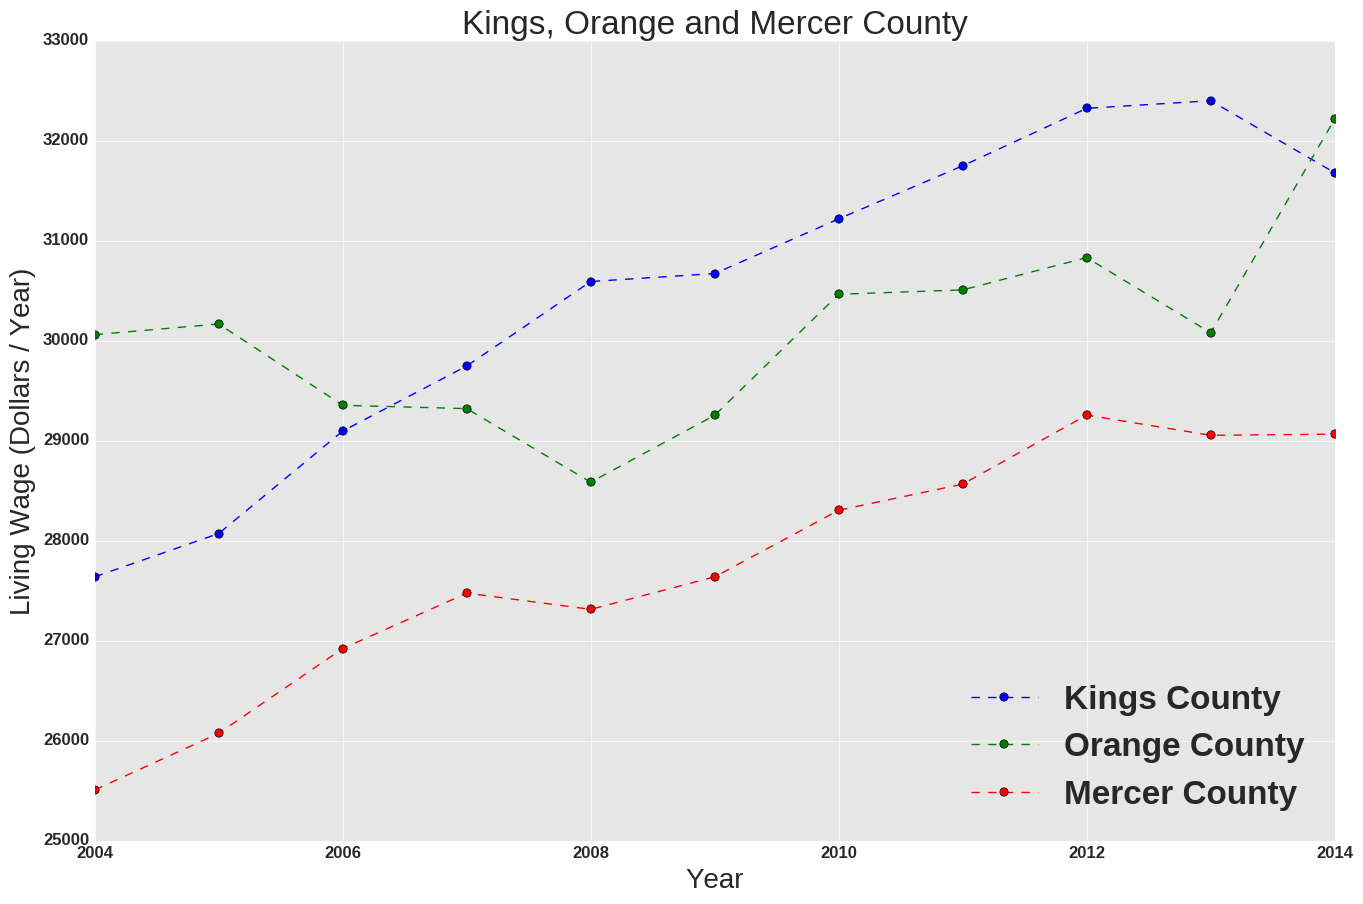

In [643]:
# Plot three counties
f = plt.figure(figsize=(16, 10))
plt.plot(final_model_values_df.loc[kings_county]['year'], 
         final_model_values_df.loc[kings_county]['total_cost'], linestyle='--', marker='o', label="Kings County")
plt.plot(final_model_values_df.loc[orange_county]['year'], 
         final_model_values_df.loc[orange_county]['total_cost'], linestyle='--', marker='o', label="Orange County")
plt.plot(final_model_values_df.loc[mercer_county]['year'], 
         final_model_values_df.loc[mercer_county]['total_cost'], linestyle='--', marker='o', label="Mercer County")

f.axes[0].set_title('Kings, Orange and Mercer County')
f.axes[0].set_ylabel('Living Wage (Dollars / Year)')
f.axes[0].set_xlabel('Year')
l = f.axes[0].legend(loc='lower right')

## State Averages of the Living Wage

([TOC](#Table-of-Contents))

**TODO:** 

* Add more analysis and comparisons of state averages
* Proper population weighting (DONE)

First, lets calculate the state averages:

In [686]:
state_weighted_averages = { }
for state in state_to_statename_mapping.keys():
    subdf = final_model_values_df[ final_model_values_df['state'] == state ][["year", "pop", "total_cost"]].reset_index("fips")
    subdf["weighted_total_cost"] = subdf["total_cost"] * subdf["pop"]
    subdf_grouped = subdf.groupby("year")
    state_weighted_averages[state] = subdf_grouped["weighted_total_cost"].sum() / subdf_grouped["pop"].sum() 
# print state_averages["NY"]

Here, I will compare the average living wge in NJ compared to NY:

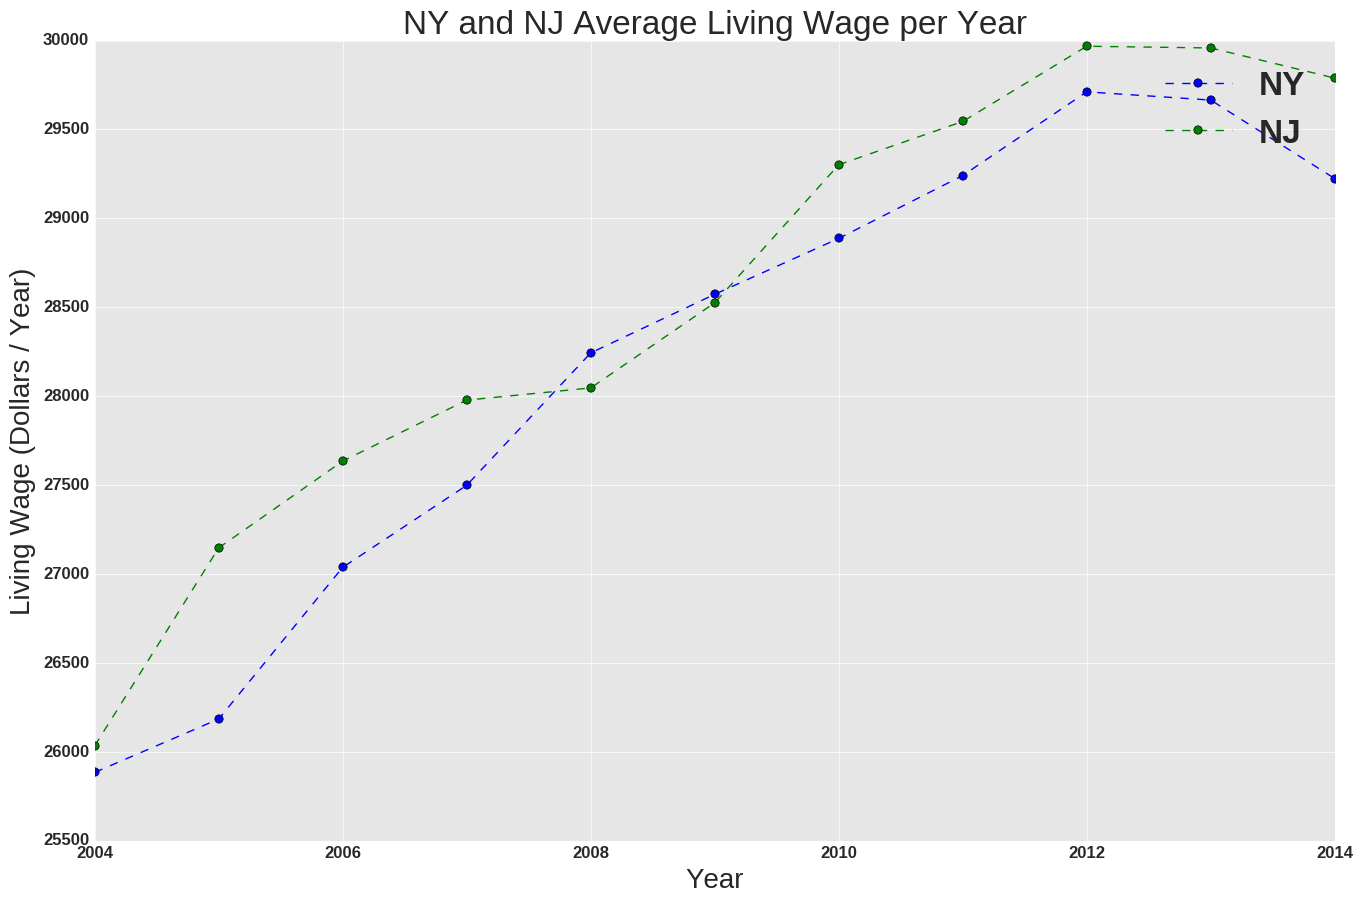

In [688]:
# Plot data for New York and NJ
f = plt.figure(figsize=(16, 10))
state_weighted_averages["NY"].plot(label="NY", linestyle='--', marker='o')
state_weighted_averages["NJ"].plot(label="NJ", linestyle='--', marker='o')
f.axes[0].set_title('NY and NJ Average Living Wage per Year')
f.axes[0].set_ylabel('Living Wage (Dollars / Year)')
f.axes[0].set_xlabel('Year')
l = f.axes[0].legend()

## Regional Averages of the Living Wage

([TOC](#Table-of-Contents))

Lets look at all the states within a region.

**TODO** 

* The issue with counties from 2005 - 2006 predominately affects the eastern states; fix in FMR section above
* Give a breakdown per region
* Proper weighted averages (DONE)

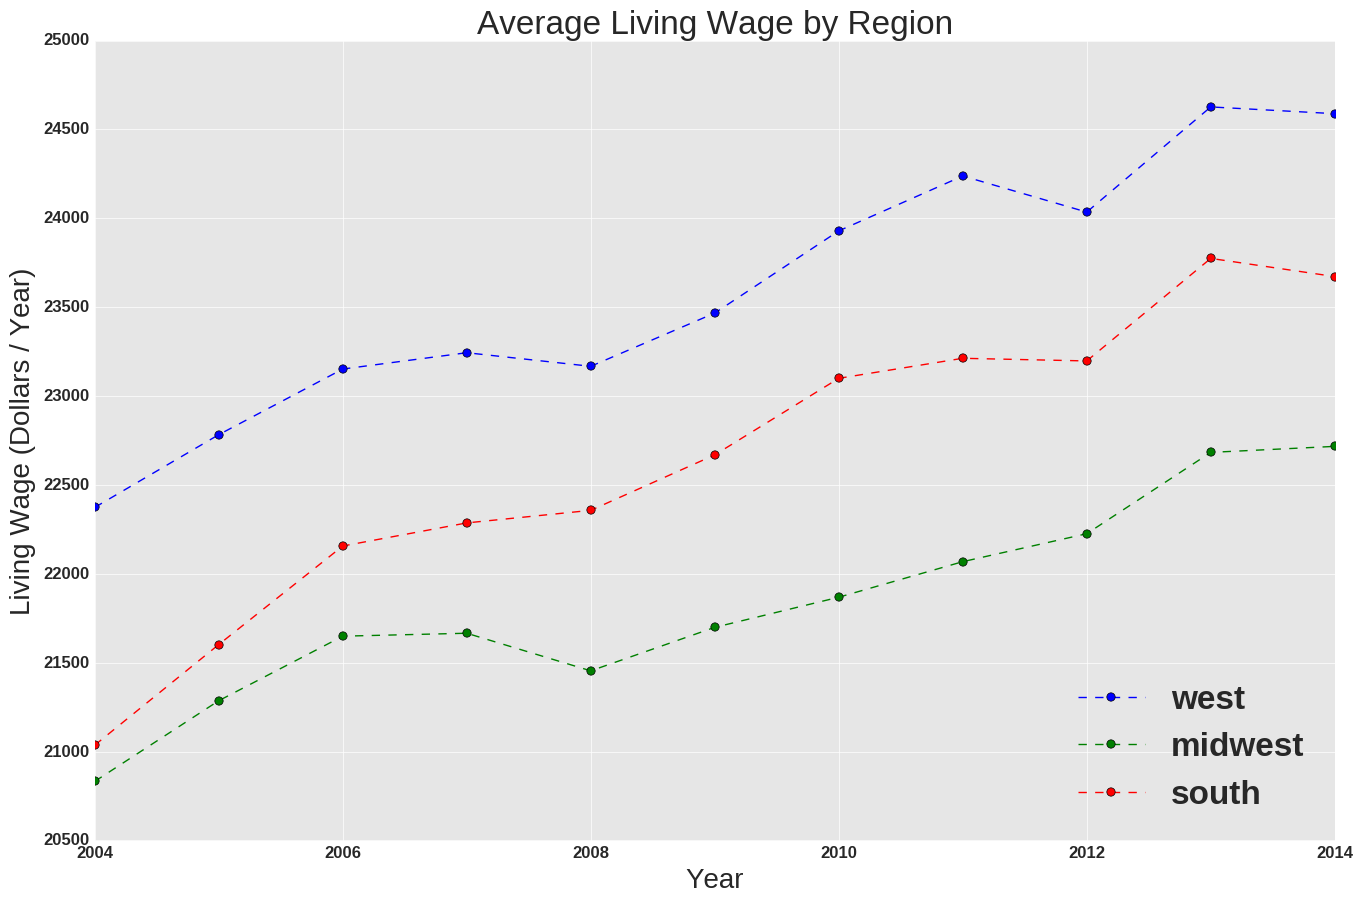

In [689]:
# final_model_values_df[ final_model_values_df['state'].isin(region_to_state_mapping[REGION_EAST]) ]
region_weighted_averages = { }

for region in region_to_state_mapping.keys():
    region_weighted_averages[region] = pd.concat([state_weighted_averages[state] for state in region_to_state_mapping[region]], axis=1) 

del region_weighted_averages['base']
del region_weighted_averages['east']    

f = plt.figure(figsize=(16, 10))

for region in region_weighted_averages:
    region_weighted_averages[region].apply(np.average, axis=1).plot(label=region, linestyle='--', marker='o')

f.axes[0].set_title('Average Living Wage by Region')
f.axes[0].set_ylabel('Living Wage (Dollars / Year)')
f.axes[0].set_xlabel('Year')
l = f.axes[0].legend(loc="lower right")

## National Average Breakdown Across 2004 - 2014

([TOC](#Table-of-Contents))

Lets see how the model variables changed over the course of a decade from the perspective of a national average, weighed by population.

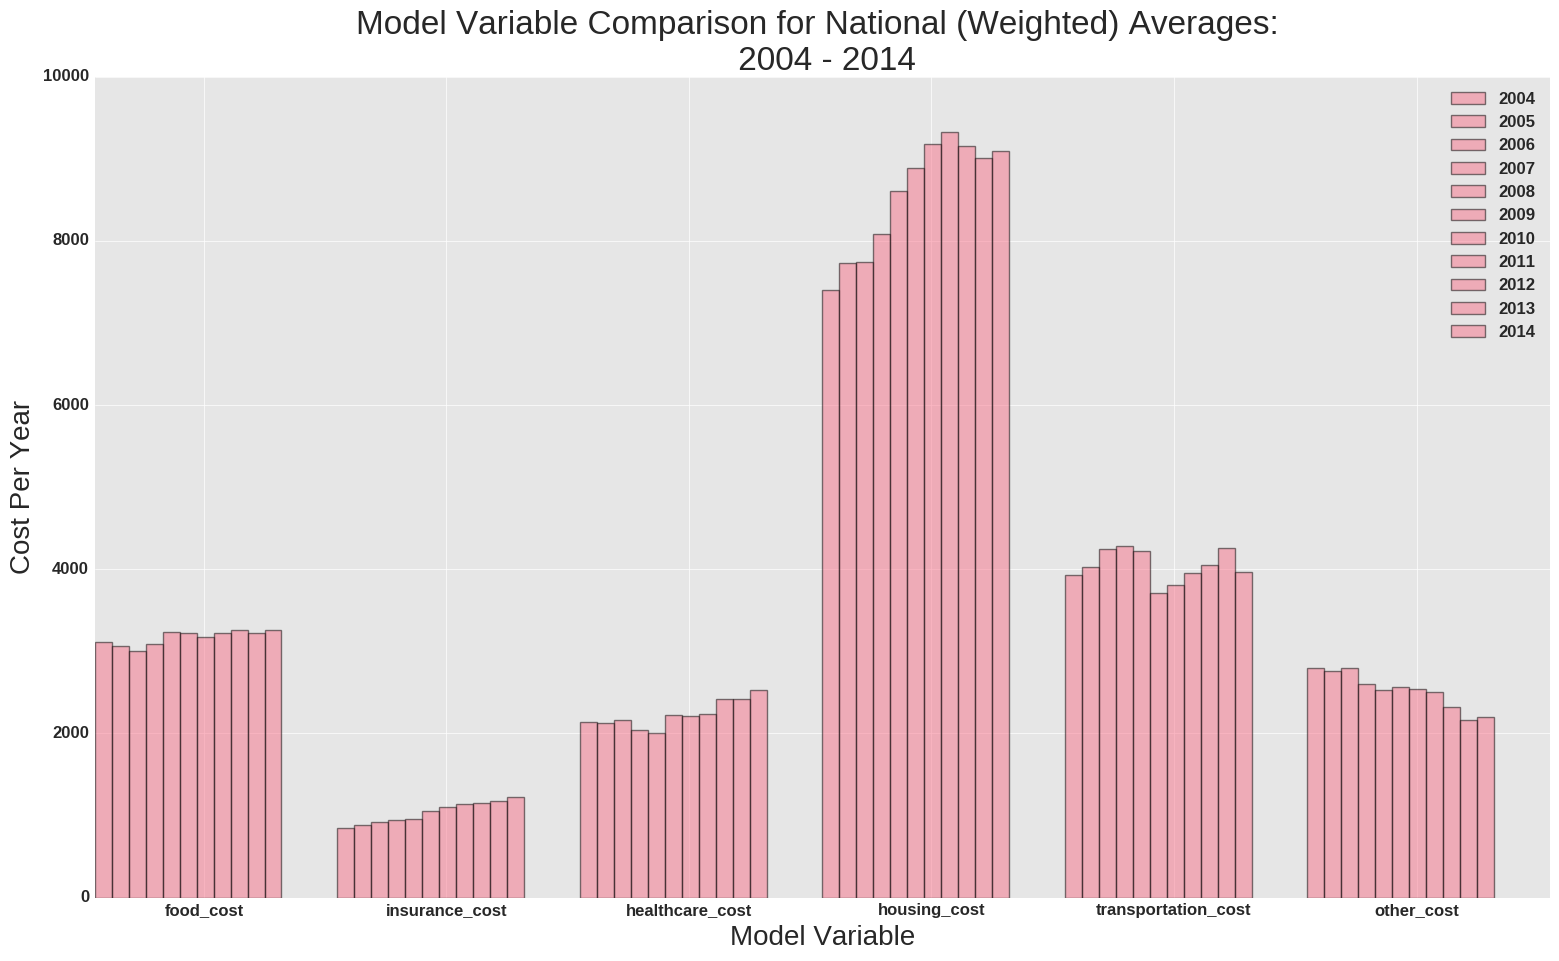

In [995]:
fig, ax = plt.subplots(figsize=(16, 10))

husl_color_palette = sns.color_palette("husl", len(model_years))

index = np.arange(6)
bar_width = 0.07

model_variable_columns = ['pop', 'food_cost', 'insurance_cost', 'healthcare_cost', 'housing_cost', 'transportation_cost', 'other_cost']

for idx, year in enumerate(model_years):
    data = final_model_values_df[ final_model_values_df['year'] == year ][model_variable_columns]
    
    weighted_data = []
    for column in model_variable_columns[1:]:
        weighted_data.append(sum(data['pop'] * data[column]) / sum(data['pop']))
    weighted_series = pd.Series(weighted_data, index=model_variable_columns[1:])

    rects1 = plt.bar(index + idx*bar_width, weighted_series, bar_width, alpha=0.5, color=husl_color_palette[0])

plt.xlabel('Model Variable')
plt.ylabel('Cost Per Year')
plt.title('Model Variable Comparison for National (Weighted) Averages: \n 2004 - 2014')
plt.xticks(index + 9*width/2, national_average_2004.index)
plt.legend(labels=model_years, fontsize=12)
plt.tight_layout()
plt.show()

## Living Wage Distribution in Most Populous Counties

([TOC](#Table-of-Contents))

[This article from Business Insider](http://www.businessinsider.com/half-of-the-united-states-lives-in-these-counties-2013-9) lists the top 150 counties by population. Here I look at the distribution of living wage values seperated by this grouping. 

Some observations:
* The populated county distributions are spread out more (std: 3085.70) than the non-populated one (std: 1739.76)
* The populated county distributions seem almost bimodal, with peaks at both . The non-populated counties peak at . 
  * In light of this, I seperate the most populous counties into two subgroups in the subsequent visualizations, where 'most1' are the counties in the top 150 most populous counties but with a total cost in the bottom portion of the group; 'most2', the top portion of the group

**TODO** 

* What makes up this third large group
* what model variable most explains the difference between the subgroups (DONE; ans = rent)

In [ ]:
# Three subplots sharing both x/y axes
f, ((ax11, ax12), (ax21, ax22), (ax31, ax32), (ax41, ax42), (ax51, ax52), (ax61, ax62)) = \
    plt.subplots(6, 2, sharey=True, figsize=(16, 20))
axes = [ax11, ax21, ax31, ax41, ax51, ax61, ax12, ax22, ax32, ax42, ax52, ax62]

# Caclulate the inverse of the most populous counties (which is defined in FMR section)
least_populous_fips = list(set(final_model_values_df.index.values) - set(most_populous_fips))

# Seperate the data frame based on the fip codes of the populous and non-populous counties
most_populous_living_wage_df = final_model_values_df.loc[most_populous_fips]
least_populous_living_wage_df = final_model_values_df.loc[least_populous_fips]

# Color the histograms and density plots with same color
current_color_palette = sns.color_palette()
color_nonpopulous = current_color_palette[2]
color_populous = current_color_palette[0]
point_color = 'green'

# Keep track of variances of each distro
mpvariance = []
lpvariance = []

# X-axis
x = numpy.arange(17000, 36000, 100)

split_threshold = [27500, 27500, 27500, 27500, 27500, 27500, 29000, 29500, 29500, 29500, 29500]

least_populous_maxes = []
most_populous_maxes = []
most_populous2_maxes = []

setup_default_visuals()

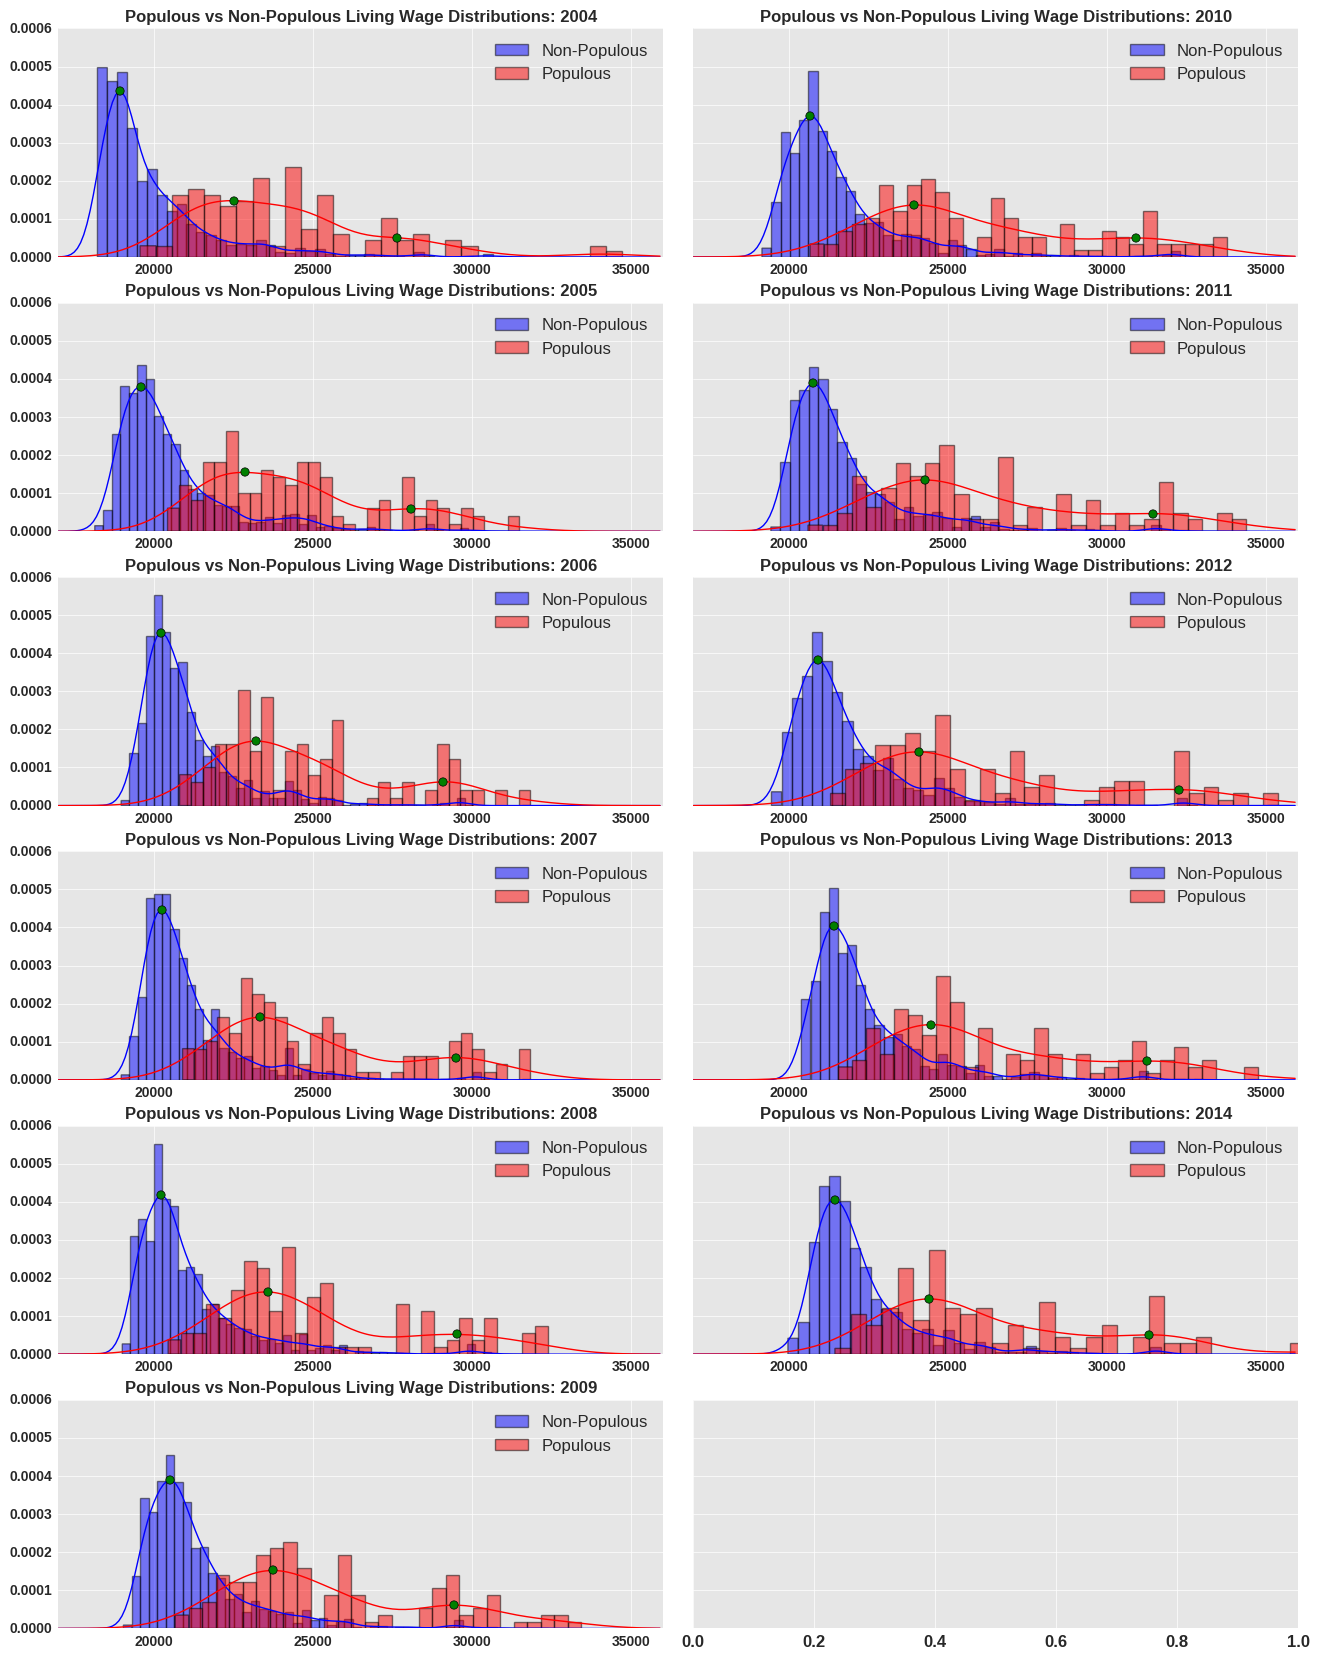

In [731]:
plot_idx = 0
for year in model_years:
    # Subset data for populous counties by year, and store variance of distribution
    most_populous_living_wage_data = most_populous_living_wage_df[ most_populous_living_wage_df["year"] == year ]["total_cost"]
    mpvariance.append(np.std(most_populous_living_wage_data))

    # Subset data for non-populous counties by year, and store variance of distribution
    least_populous_living_wage_data = least_populous_living_wage_df[ least_populous_living_wage_df["year"] == year ]["total_cost"]
    lpvariance.append(np.std(least_populous_living_wage_data))
    
    # Histogram / density plot of populous counties living wage distribution
    axes[plot_idx].hist(least_populous_living_wage_data.values, 50, normed=True, label="Non-Populous", alpha=0.5, color=color_populous)
    density = stats.kde.gaussian_kde(least_populous_living_wage_data)
    axes[plot_idx].plot(x, density(x), color=color_populous)
    
    # Least populous maxes
    least_populous_density = density(least_populous_living_wage_data.values)
    least_populous_max_idx = argmax(least_populous_density)
    axes[plot_idx].plot(least_populous_living_wage_data.values[least_populous_max_idx], 
                       least_populous_density[least_populous_max_idx], marker='o', color=point_color)
    least_populous_maxes.append(least_populous_living_wage_data.values[least_populous_max_idx])
    
    # Histogram / density plot of non-populous counties living wage distribution
    axes[plot_idx].hist(most_populous_living_wage_data.values, 30, normed=True, label="Populous", alpha=0.5, color=color_nonpopulous)
    density = stats.kde.gaussian_kde(most_populous_living_wage_data.values)
    axes[plot_idx].plot(x, density(x), color=color_nonpopulous)
    
    # Most populous maxes
    first_group = most_populous_living_wage_data[most_populous_living_wage_data <= split_threshold[plot_idx]]
    first_group_density = density(first_group.values)
    most_populous_max_idx = argmax(first_group_density)
    axes[plot_idx].plot(first_group.values[most_populous_max_idx], 
                       first_group_density[most_populous_max_idx], marker='o', color=point_color)
    most_populous_maxes.append(first_group.values[most_populous_max_idx])
    
    second_group = most_populous_living_wage_data[most_populous_living_wage_data > split_threshold[plot_idx]]
    second_group_density = density(second_group.values)
    most_populous2_max_idx = argmax(density(second_group.values))
    axes[plot_idx].plot(second_group.values[most_populous2_max_idx], 
                       second_group_density[most_populous2_max_idx], marker='o', color=point_color)
    most_populous2_maxes.append(second_group.values[most_populous2_max_idx])
    
    
    # Figure metadata and plot
    axes[plot_idx].legend(fontsize=12)
    axes[plot_idx].set_title("Populous vs Non-Populous Living Wage Distributions: %d" % year, fontsize=12, fontweight='bold')
    axes[plot_idx].set_xlim([17000, 36000])
    axes[plot_idx].tick_params(axis='both', which='major', labelsize=10)
    axes[plot_idx].tick_params(axis='both', which='minor', labelsize=10)

    # Go to next plot
    plot_idx += 1

plt.subplots_adjust(wspace=0.05)
setup_custom_visuals()

# Standard deviation
# print np.average(mpvariance) 3085.7098474
# print np.average(lpvariance) 1739.76349887

Lets look at the living wage peaks of each subgroup over time:

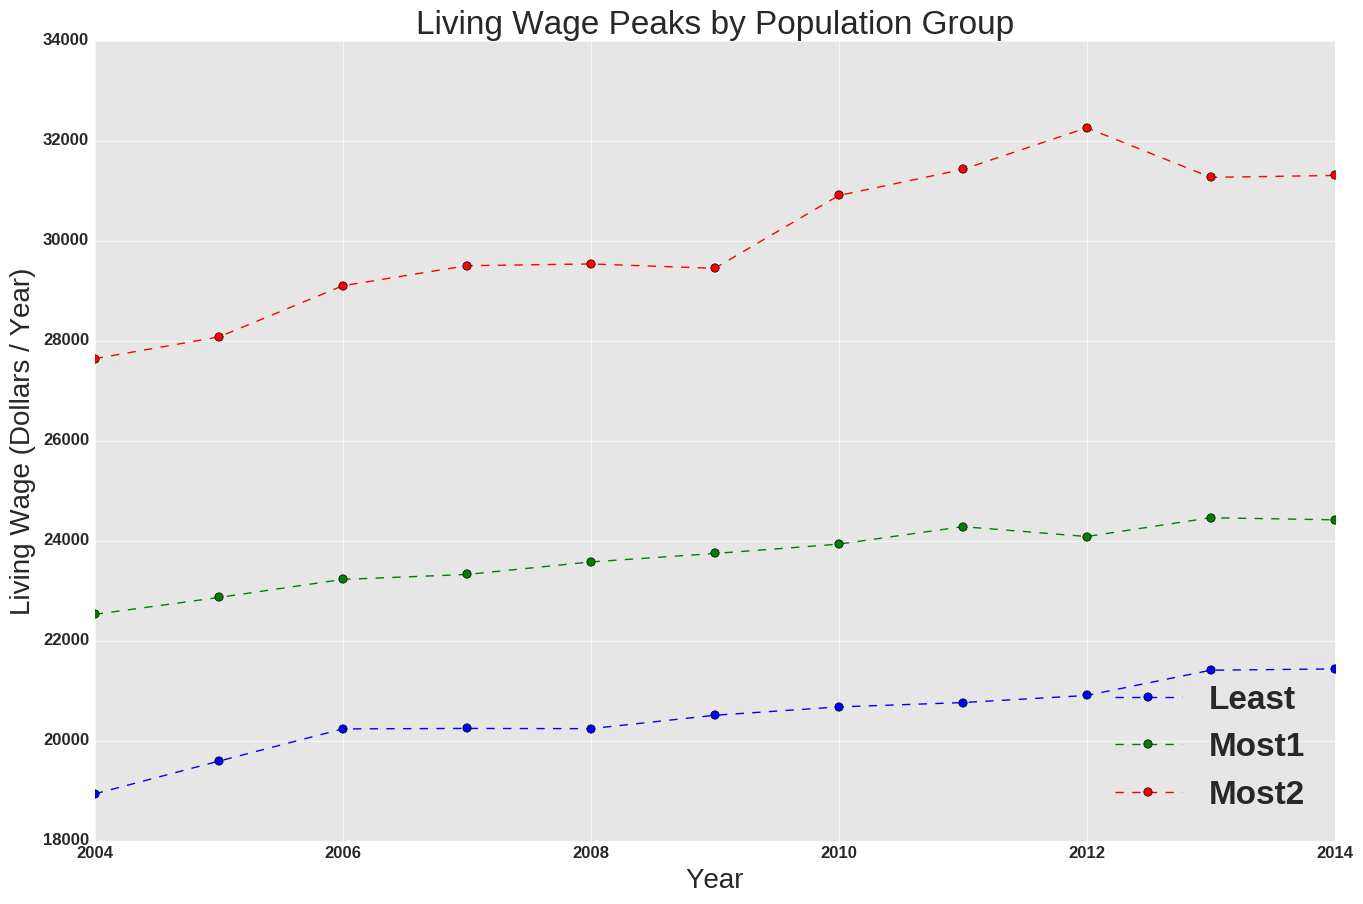

In [647]:
f = plt.figure(figsize=(16, 10))
plt.plot(model_years, least_populous_maxes, label="Least", linestyle='--', marker='o')
plt.plot(model_years, most_populous_maxes, label="Most1", linestyle='--', marker='o')
plt.plot(model_years, most_populous2_maxes, label="Most2", linestyle='--', marker='o')
f.axes[0].set_title('Living Wage Peaks by Population Group')
f.axes[0].set_ylabel('Living Wage (Dollars / Year)')
f.axes[0].set_xlabel('Year')
l = f.axes[0].legend(loc="lower right")

Whats interesting here is that the different between the peak in the least-populous county group and the two peaks in the most-populous group is very steady in value, despite a general increase over time. This seems to insinuate that living in a more populated area comes at the cost of an increase in the living wage needed, and that this cost is maintained over time.

What variables in the model account for the differences in the living wage across the least and most populated counities:

In [247]:
columns = ["food_cost", "insurance_cost", "healthcare_cost", "housing_cost", "transportation_cost", "other_cost", "total_cost"]

# Find the average model variables for least populous counties
least_populous_model_variable_averages = \
    final_model_values_df.loc[least_populous_fips].groupby("year").aggregate(np.average)
least_populous_model_variable_averages = least_populous_model_variable_averages[columns]

# For ease of coding, get subset of dataframe for the most populous counties
most_pop_df = final_model_values_df.loc[most_populous_fips]

# For each year, average model variables for each subgroup in the most populous counties
most_populous_model_variable_averages = None
most_populous2_model_variable_averages = None
for idx, year in enumerate(model_years):
    # Average the model variables across fips in the most populous counties for this year, append to df
    if most_populous_model_variable_averages is not None:
        most_populous_model_variable_averages = pd.concat([most_populous_model_variable_averages, most_pop_df[ most_pop_df["total_cost"] <= split_threshold[idx] ].loc[most_populous_fips]])
    else:
        most_populous_model_variable_averages = most_pop_df[ most_pop_df["total_cost"] <= split_threshold[idx] ].loc[most_populous_fips]

        
    # Average the model variables across fips in the most populous counties for this year, append to df
    if most_populous2_model_variable_averages is not None:
        most_populous2_model_variable_averages = pd.concat([most_populous2_model_variable_averages, most_pop_df[ most_pop_df["total_cost"] > split_threshold[idx] ].loc[most_populous_fips]])
    else:
        most_populous2_model_variable_averages = most_pop_df[ most_pop_df["total_cost"] > split_threshold[idx] ].loc[most_populous_fips]

# Aggregated by year and take an average; filter out only useful variables (tax rates hardly change)
most_populous_model_variable_averages = most_populous_model_variable_averages.groupby("year").aggregate(np.average)
most_populous_model_variable_averages = most_populous_model_variable_averages[columns]
most_populous2_model_variable_averages= most_populous2_model_variable_averages.groupby("year").aggregate(np.average)
most_populous2_model_variable_averages = most_populous2_model_variable_averages[columns]

# Differences between the model variables between each subgroup
model_variable_diffs = pd.concat([(most_populous2_model_variable_averages - most_populous_model_variable_averages).apply(np.average).transpose(),
                                (most_populous2_model_variable_averages - least_populous_model_variable_averages).apply(np.average).transpose(),
                                (most_populous_model_variable_averages - least_populous_model_variable_averages).apply(np.average).transpose()], axis=1)

# Print nicely
model_variable_diffs.columns = ['Diff Most2 and Most Pop', 'Diff Most2 and Least Pop', 'Diff Most1 and Least Pop']
formatters = { column:'${:,.2f}'.format for column in model_variable_diffs.columns }
HTML(model_variable_diffs.to_html(formatters=formatters))

,Diff Most2 and Most Pop,Diff Most2 and Least Pop,Diff Most1 and Least Pop
food_cost,$208.63,$304.05,$95.42
insurance_cost,$18.98,$21.69,$2.71
healthcare_cost,$0.00,$0.00,$0.00
housing_cost,"$5,336.68","$7,789.75","$2,453.06"
transportation_cost,$-0.00,$-0.00,$-0.00
other_cost,$0.00,$0.00,$-0.00
total_cost,"$6,262.14","$9,133.61","$2,871.47"


As we can see, that majority of the average difference between these sub-groups is the housing cost variable, followed by food costs and then insurance cost. Note: since we are not doing regional weighting on the CEX data, the three variables derived from them are the same nationally. Hence we expect no change between these variables. This should be looked into after an appropriate regional weighting scheme is found.

Another avenue for investigation is to look into each sub-group and see what percentage each individial model variable accounts for in the total cost average for that sub-group. We will only look at 2014:

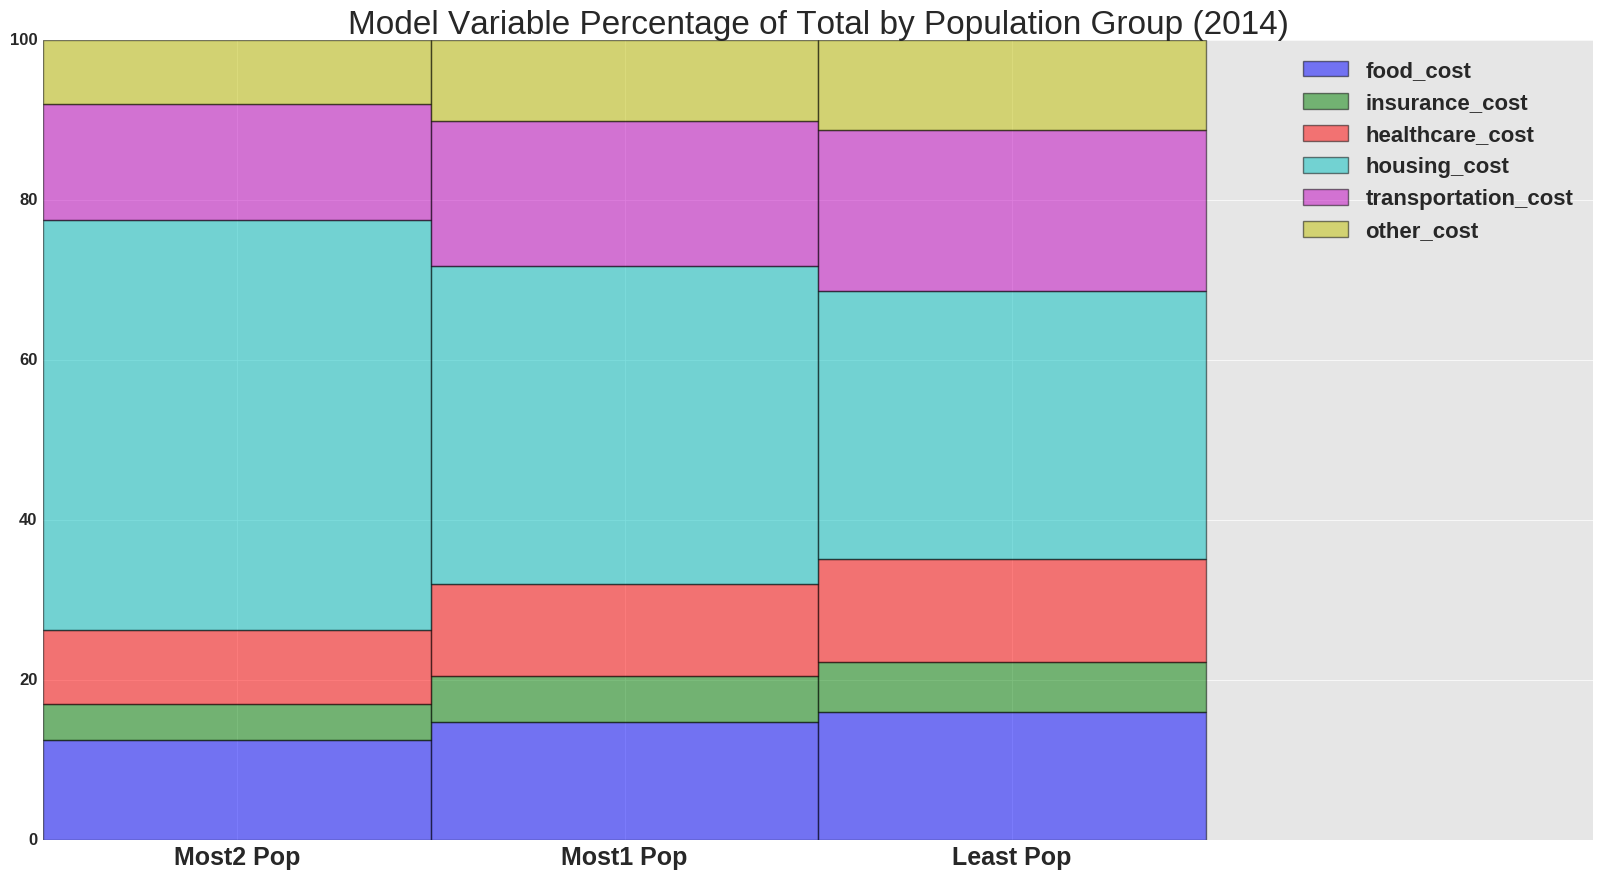

In [751]:
# Percent change in the averages of the model variables broken down by population group
most_populous2_model_variable_perc = most_populous2_model_variable_averages.apply(lambda x: x * 100.0 / sum(x[:-1]), axis=1)
most_populous_model_variable_perc = most_populous_model_variable_averages.apply(lambda x: x * 100.0 / sum(x[:-1]), axis=1)
least_populous_model_variable_perc = least_populous_model_variable_averages.apply(lambda x: x * 100.0 / sum(x[:-1]), axis=1)

# Differences between the model variables between each subgroup for 2014
model_variable_percs = pd.concat([most_populous2_model_variable_perc.loc[model_years[-1]],
                                most_populous_model_variable_perc.loc[model_years[-1]],
                                least_populous_model_variable_perc.loc[model_years[-1]]], axis=1)

# No need for total_cost anymore
model_variable_percs = model_variable_percs[:-1]

model_variable_percs.columns = ['Most2 Pop', 'Most1 Pop', 'Least Pop']

# Create a 1 x 3 figure of stacked bar
fig = plt.figure(figsize=(20, 10))
ax = fig.gca()

width = 0.1
idx = [0, width, 2*width]
xtick_idx = [width/2, 3*width/2, 5*width/2]

data = None
prev_data = None
for rowidx in range(len(model_variable_percs)):
    color = current_color_palette[rowidx]
    data = model_variable_percs.iloc[rowidx]
    if prev_data is not None:
        ax.bar(idx, data, width, bottom=prev_data, color=color, alpha=0.5)
        prev_data += data
    else:
        ax.bar(idx, data, width, color=color, alpha=0.5)
        prev_data = data

# Add legend,title and Adjust x-axis labels and limits
ax.legend(labels=model_variable_percs.index, prop={'size':16})
ax.set_title("Model Variable Percentage of Total by Population Group (2014)")
plt.xticks(xtick_idx, model_variable_percs.columns, fontsize=18)
ax.set_xlim(0, 4*width)

plt.show()

**TODO:** Add some more analysis

## Loading Race Data from 2010 Census

In [1165]:
census_race_data_df = pd.DataFrame.from_csv(open("/home/james/Code/Masters/Thesis/data/census/aff_download/DEC_10_DP_DPDP1_with_ann_stripped.csv", "r"))
census_race_columns = ["GEO.display-label", "HD02_S078", "HD02_S079", "HD02_S080", "HD02_S081", 
                       "HD02_S089", 
                       "HD02_S114","HD02_S115","HD02_S116","HD02_S117","HD02_S118","HD02_S119"]
census_race_data_df = census_race_data_df[census_race_columns]
census_race_data_df.columns = ["Label", "white_perc", "black_perc", "american_indian_perc", "asian_perc", 
                               "pacific_islander_perc", 
                               "hispanic_perc", "hispanic_white_perc", "hispanic_black_perc", "hispanic_american_indian_perc", 
                               "hispanic_asian_perc", "hispanic_pacific_islander_perc"]

census_races = census_race_data_df.columns[1:6]
                                   
# adjust for lations
for race in census_races:
    census_race_data_df[race] = census_race_data_df[race] - census_race_data_df["hispanic_" + race]

census_races = [ "_".join(race.split('_')[0:-1]) for race in census_race_data_df.columns[1:7] ]

census_race_data_df.index = census_race_data_df.index.map(lambda x: int(x.split("US")[1] + '99999'))

### Living Wage Breakdown by Race

([TOC](#Table-of-Contents))

**TODO**

* Why does 2004 and 2005 not work in this breakdown?
* Right now using only 2010 census data; can I get it for 2000?
* What % of race has living wage above some threshold
* histogram of counties seperated by race (DONE)
* histogram of living wage distribution by race
* race averages over time

### Living Wage County Breakdown by Race

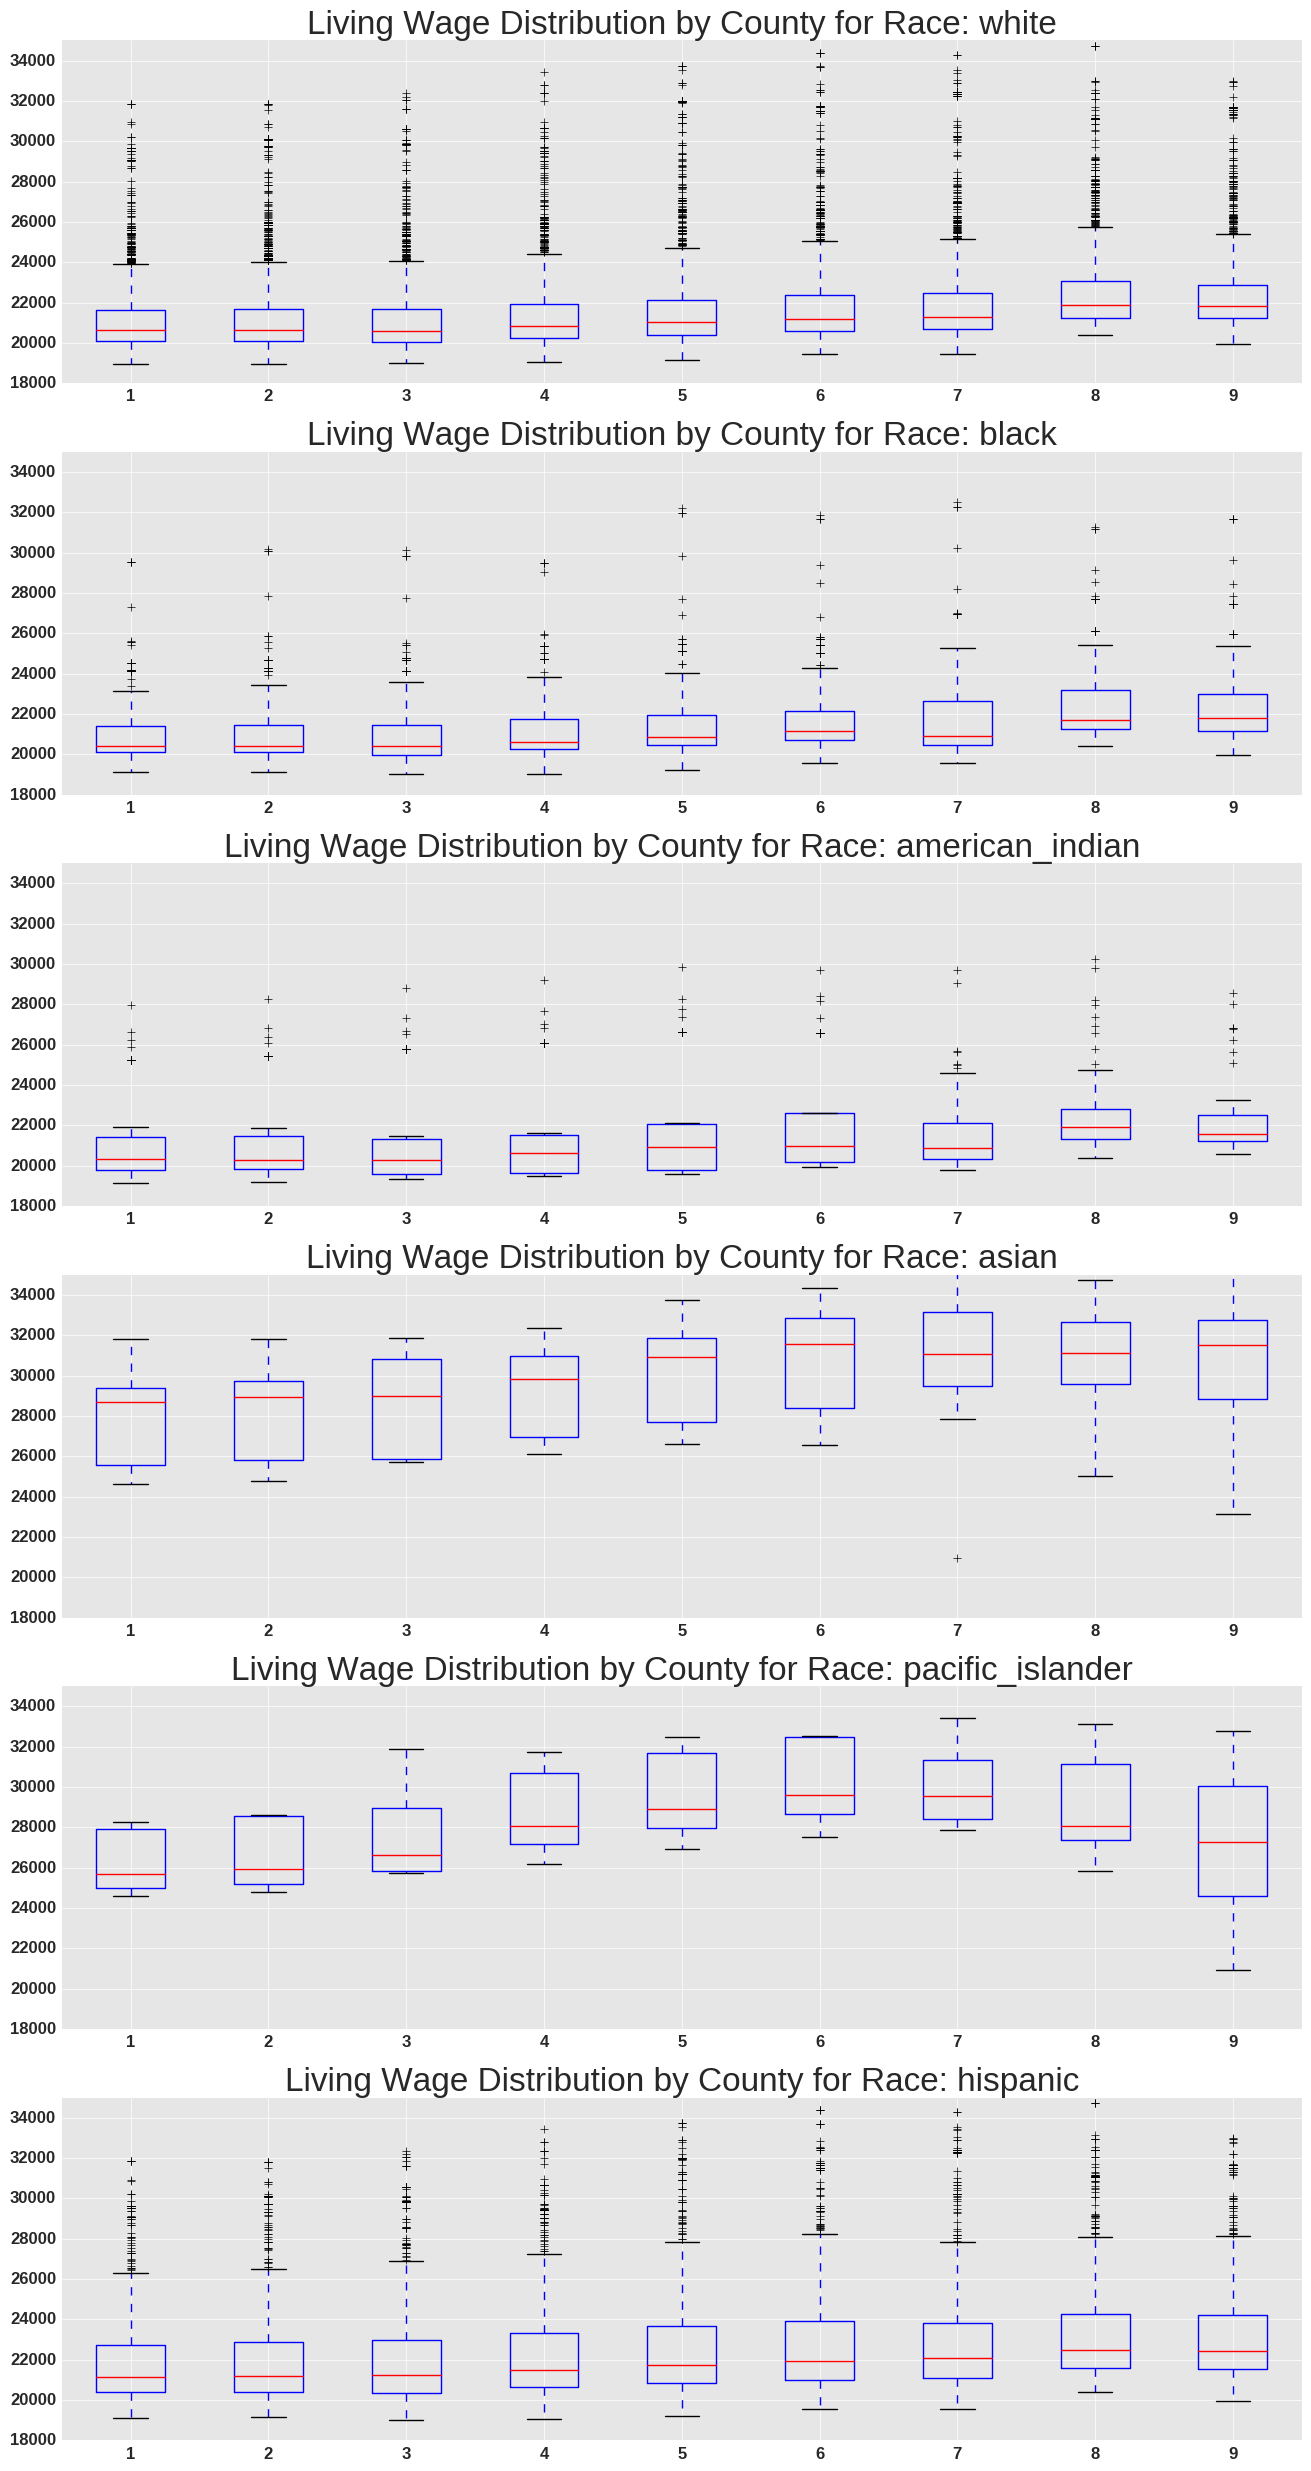

In [1214]:
race_years = range(2006, 2015)
num_race_years = len(race_years)
race_density = defaultdict(dict)
race_counties = defaultdict(dict)

thresholds = [ 35.0, 35.0, 20.0, 20.0, 5.0, 5.0, 35.0 ]

f, axes = plt.subplots(len(census_races), 1, sharey=True, figsize=(16, 30))
alpha = 0.2
plot_idx = 0

for idx, race in enumerate(census_races):
    boxplot_data = []
    for year in race_years:
        subdf = final_model_values_df[final_model_values_df['year'] == year].join(census_race_data_df).dropna()
        race_counties[race] = subdf[census_race_data_df.columns[1:]].apply(lambda x: x[race + "_perc"] > thresholds[idx], axis=1)
        boxplot_data.append(subdf[race_counties[race]]["total_cost"])
        race_density[race][year] = stats.kde.gaussian_kde(subdf[race_counties[race]]["total_cost"])

    axes[plot_idx].boxplot(boxplot_data)
    axes[plot_idx].set_title("Living Wage Distribution by County for Race: %s" % race)
    axes[plot_idx].set_ylim((18000, 35000))
    plot_idx += 1

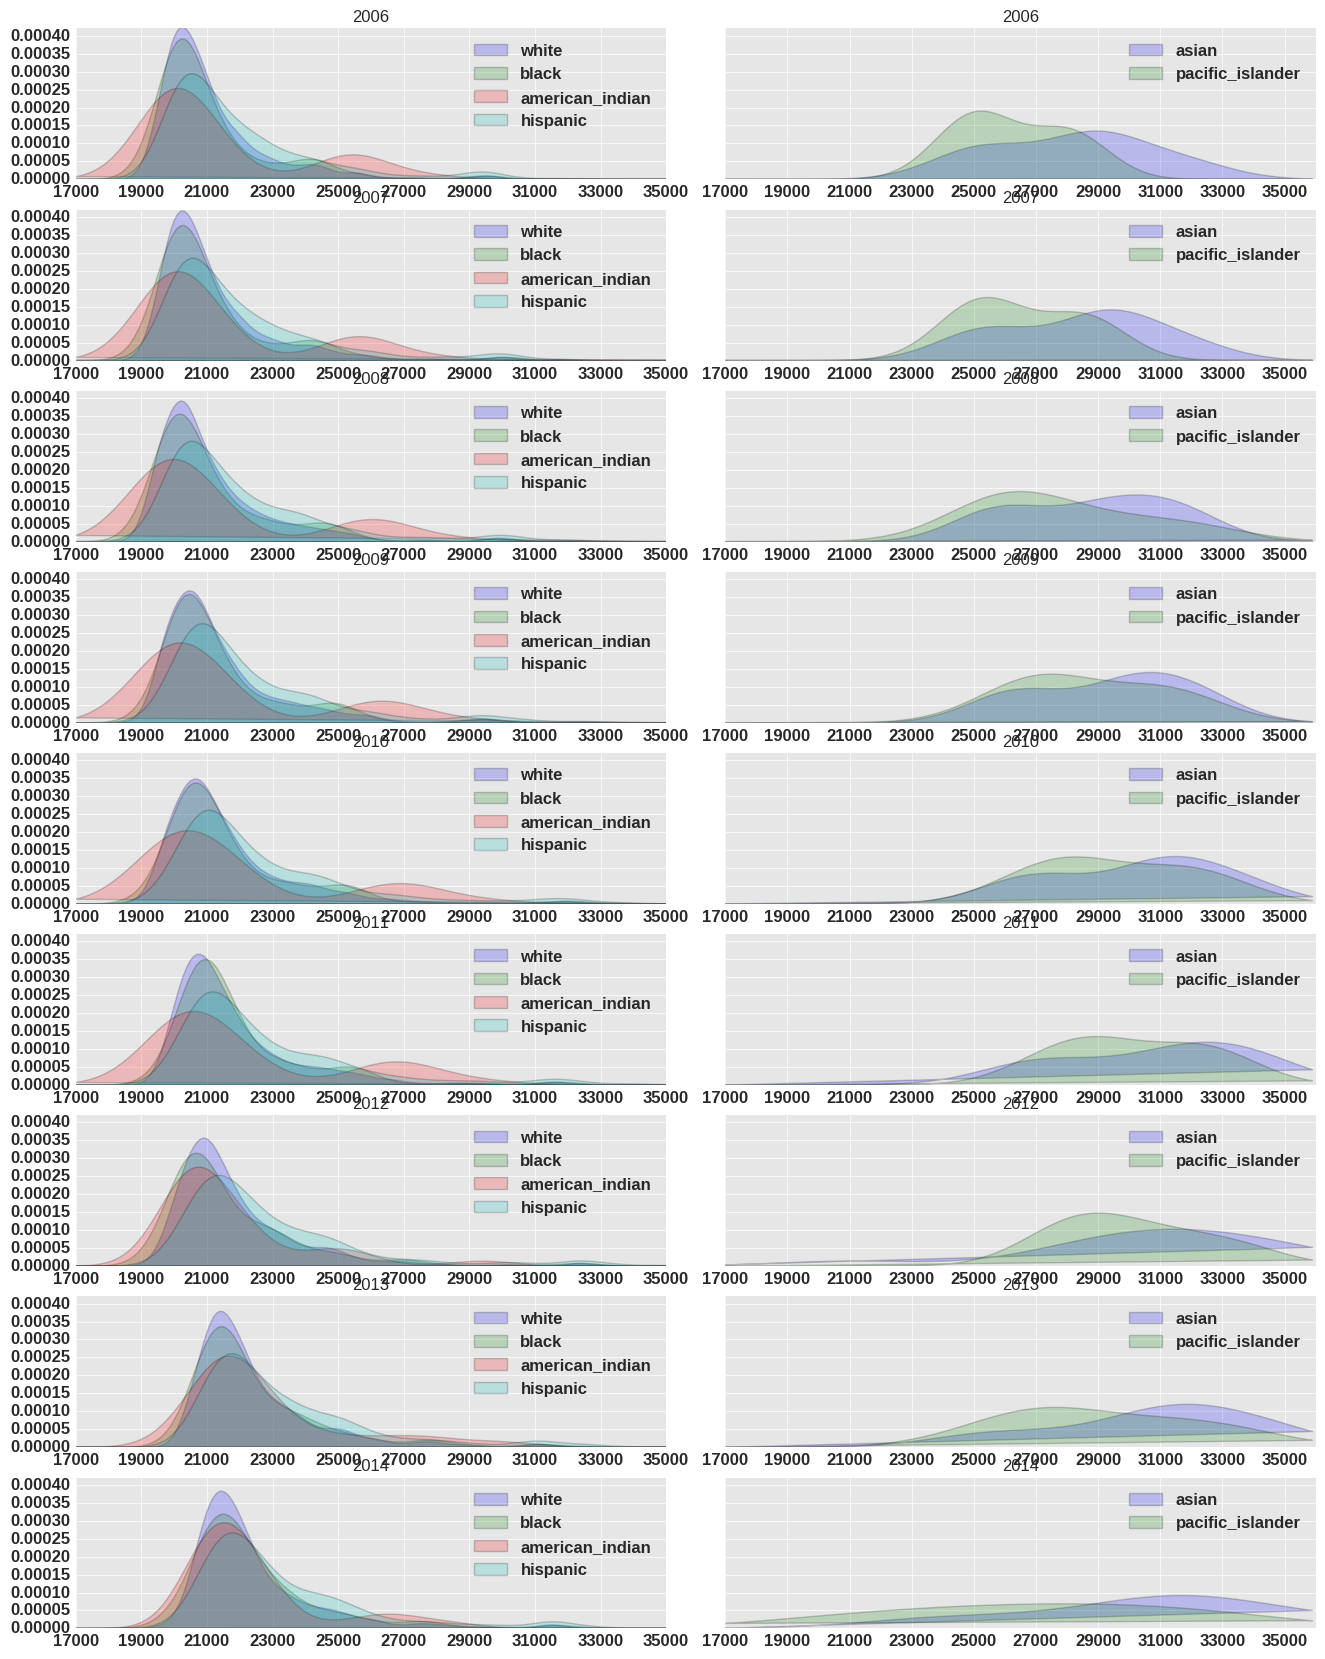

In [1268]:
f, ((ax11, ax12), (ax21, ax22), (ax31, ax32), (ax41, ax42), (ax51, ax52), (ax61, ax62), (ax71, ax72), (ax81, ax82), (ax91, ax92)) = \
    plt.subplots(num_races, 2, sharey=True, figsize=(16, 20))
axes = [ax11, ax21, ax31, ax41, ax51, ax61, ax71, ax81, ax91, ax12, ax22, ax32, ax42, ax52, ax62, ax72, ax82, ax92]

alpha = 0.2
x = numpy.arange(17000, 36000, 100)
plot_idx = 0

races_group1 = ["white", "black", "american_indian", "hispanic"]
races_group2 = ["asian", "pacific_islander"]

for year in race_years:
    for race in races_group1:
        axes[plot_idx].fill(x, race_density[race][year](x), alpha=alpha)#, color=current_color_palette[0])
        # axes[plot_idx].fill(x, race_density["white"][year](x), alpha=alpha)#, color=current_color_palette[0])
        # axes[plot_idx].fill(x, race_density["black"][year](x), alpha=alpha)#, color=current_color_palette[0])
        # axes[plot_idx].fill(x, race_density["american_indian"][year](x), alpha=alpha)#, color=current_color_palette[0])
        # axes[plot_idx].fill(x, race_density["hispanic"][year](x), alpha=alpha)#, color=current_color_palette[0])    
    
    axes[plot_idx].set_title(year,  fontsize=12)
    axes[plot_idx].legend(labels=races_group1, fontsize=12)
    axes[plot_idx].set_xlim((17000, 31000))
    axes[plot_idx].set_ylim((0, 0.00042))
    axes[plot_idx].set_xticks(range(17000, 36000, 2000))
    
    for race in races_group2:
        axes[plot_idx + num_races].fill(x, race_density[race][year](x), alpha=alpha)#, color=current_color_palette[0])
        # axes[plot_idx + num_race_years].fill(x, race_density["asian"][year](x), alpha=alpha)#, color=current_color_palette[0])
        # axes[plot_idx + num_race_years].fill(x, race_density["pacific_islander"][year](x), alpha=alpha)#, color=current_color_palette[0])
    
    axes[plot_idx + num_race_years].set_title(year,  fontsize=12)
    axes[plot_idx + num_race_years].legend(labels=races_group2, fontsize=12)
    axes[plot_idx + num_race_years].set_xlim((17000, 36000))
    axes[plot_idx + num_race_years].set_ylim((0, 0.00042))
    axes[plot_idx + num_race_years].set_xticks(range(17000, 36000, 2000))
    
    # Go to next plot
    plot_idx += 1

f.subplots_adjust(wspace=0.1)
setup_custom_visuals()

### Living Wage Population Breakdown by Race

**TODO: ** Show boxplot

In [ ]:
# race_density = defaultdict(dict)
# race_counties = defaultdict(dict)

# thresholds = [ 35.0, 35.0, 20.0, 20.0, 5.0, 5.0, 35.0 ]

# f, axes = plt.subplots(len(census_races), 1, sharey=True, figsize=(16, 30))
# alpha = 0.2
# plot_idx = 0

# for idx, race in enumerate(census_races):
#     boxplot_data = []
#     for year in race_years:
#         subdf = final_model_values_df[final_model_values_df['year'] == year].join(census_race_data_df).dropna()
#         race_counties[race] = subdf[census_race_data_df.columns[1:]].apply(lambda x: x[race + "_perc"] > thresholds[idx], axis=1)
#         boxplot_data.append(subdf[race_counties[race]]["total_cost"])
#         race_density[race][year] = stats.kde.gaussian_kde(subdf[race_counties[race]]["total_cost"])

#     axes[plot_idx].boxplot(boxplot_data)
#     axes[plot_idx].set_title("Living Wage Distribution by County for Race: %s" % race)
#     axes[plot_idx].set_ylim((18000, 35000))
#     plot_idx += 1

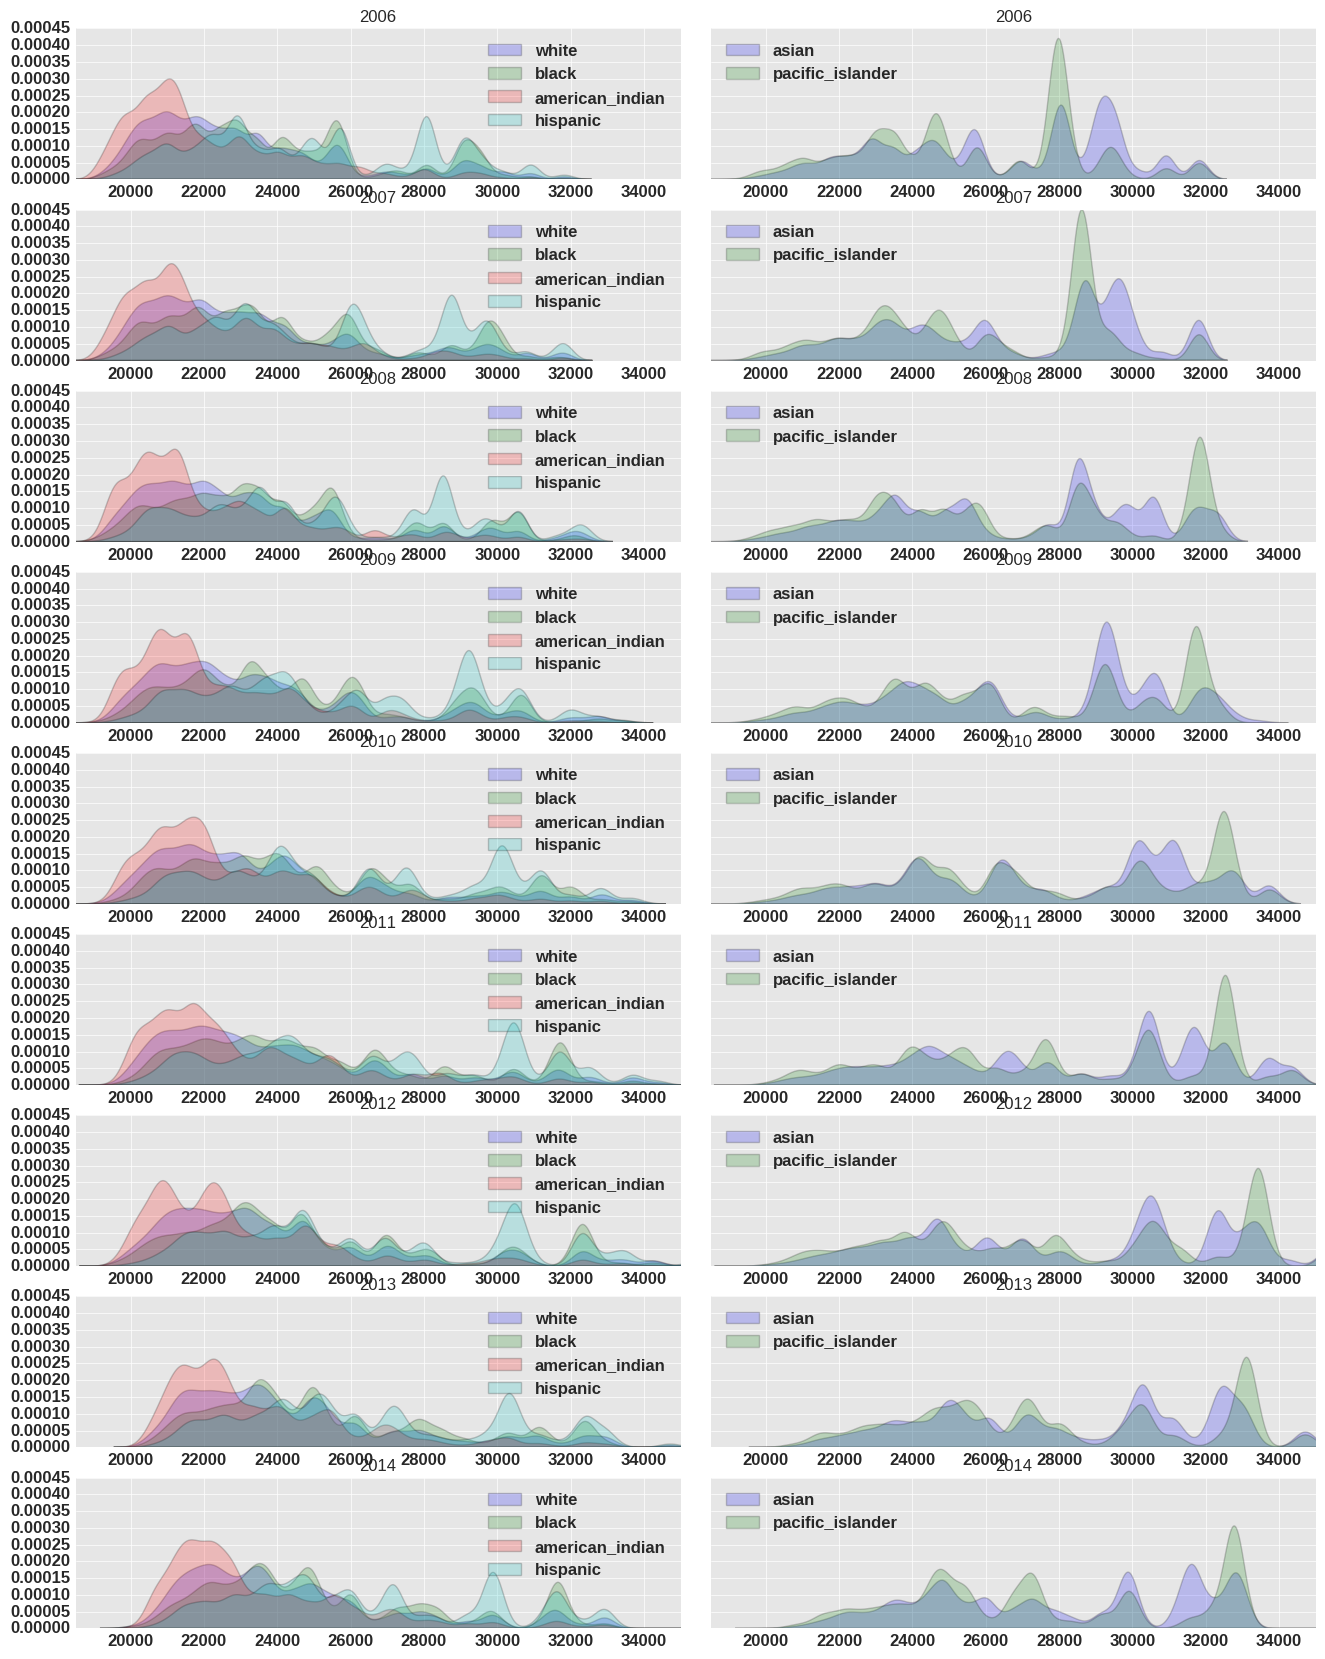

In [1272]:
f, ((ax11, ax12), (ax21, ax22), (ax31, ax32), (ax41, ax42), (ax51, ax52), (ax61, ax62), (ax71, ax72), (ax81, ax82), (ax91, ax92)) = \
    plt.subplots(num_races, 2, sharey=True, figsize=(16, 20))
axes = [ax11, ax21, ax31, ax41, ax51, ax61, ax71, ax81, ax91, ax12, ax22, ax32, ax42, ax52, ax62, ax72, ax82, ax92]

# weighted_costs = defaultdict(dict)

plot_idx = 0
for year in race_years:
    subdf = final_model_values_df[final_model_values_df['year'] == year].join(census_race_data_df).dropna()

#     for race in census_races:
#         subdf[race + '_pop'] = (subdf['pop'] * (subdf[race + '_perc'] / 100.0)).map(int)
#         weighted_cost = sm.nonparametric.KDEUnivariate(subdf["total_cost"])
#         weighted_cost.fit(fft=False, weights=subdf[race + '_pop'])
#         weighted_costs[year][race] = weighted_cost
    
    for race in races_group1:
        axes[plot_idx].fill(weighted_costs[year][race].support, weighted_costs[year][race].density, alpha=alpha)
        
    axes[plot_idx].set_title(year,  fontsize=12)
    axes[plot_idx].legend(races_group1, fontsize=12, loc="upper right")
    axes[plot_idx].set_xlim((18500, 35000))
    # axes[plot_idx].set_ylim((0.00, 0.10))
    
    for race in races_group2:
        axes[plot_idx + num_race_years].fill(weighted_costs[year][race].support, weighted_costs[year][race].density, alpha=alpha)
        
    axes[plot_idx + num_race_years].set_title(year,  fontsize=12)
    axes[plot_idx + num_race_years].legend(races_group2, fontsize=12, loc="upper left")
    axes[plot_idx + num_race_years].set_xlim((18500, 35000))
    # axes[plot_idx].set_ylim((0.00, 0.10))
    
    # Go to next plot
    plot_idx += 1

plt.subplots_adjust(wspace=0.05)
setup_custom_visuals()

### Population Weighted Averages Broken Down By Race

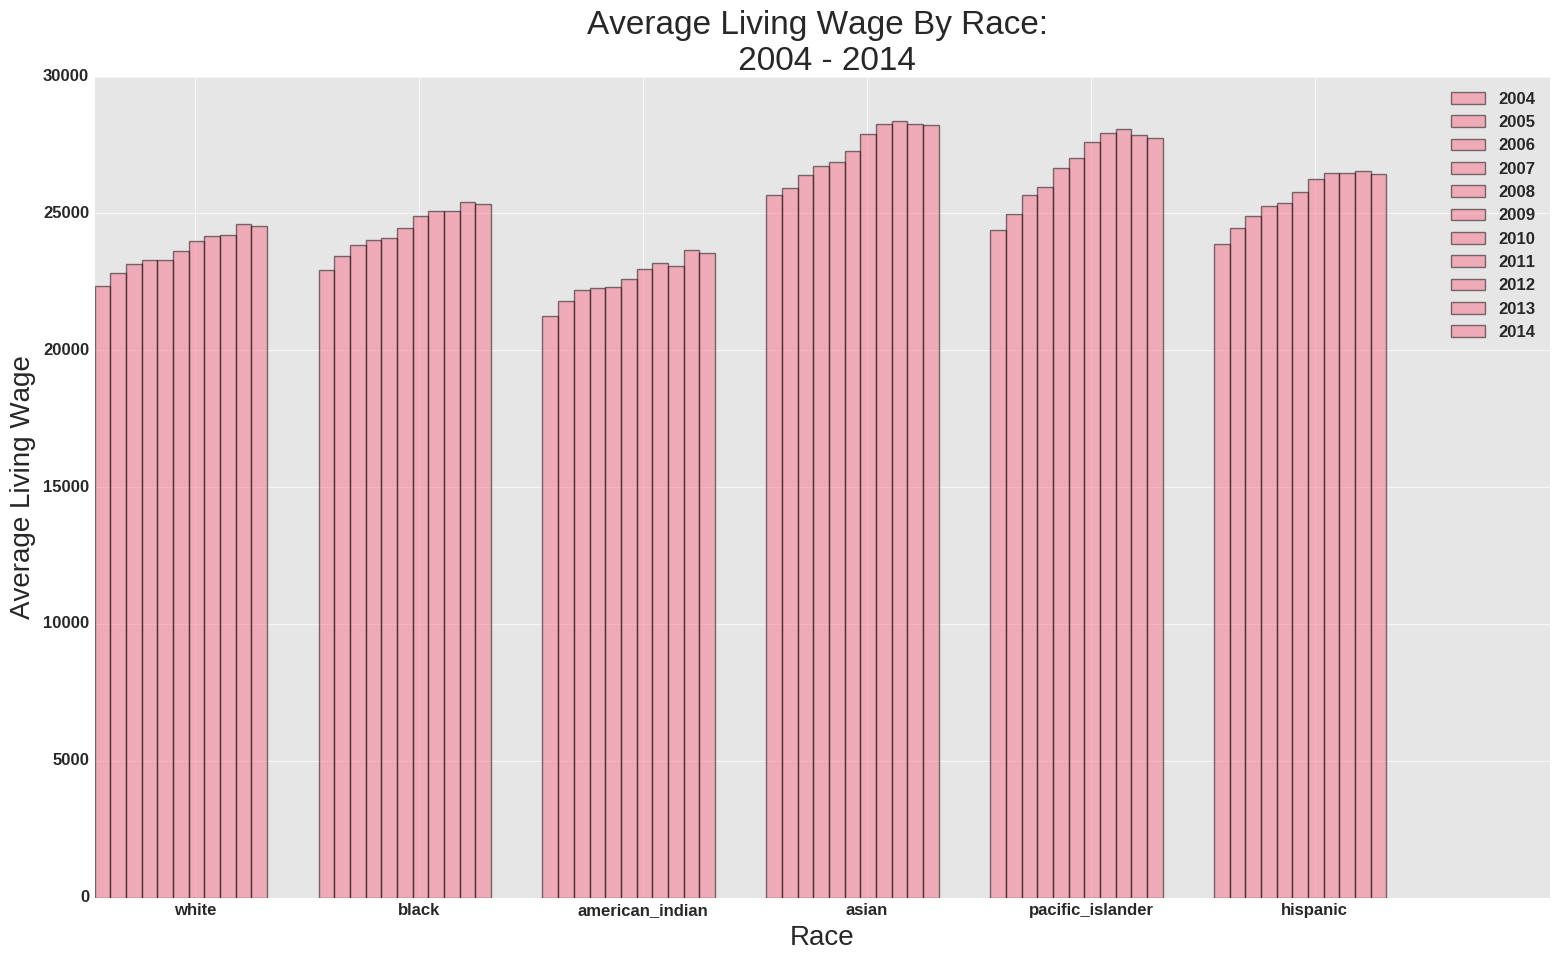

In [1274]:
fig, ax = plt.subplots(figsize=(16, 10))
index = np.arange(len(census_races))
bar_width = 0.07

for idx, year in enumerate(model_years):
    race_points = []
    subdf = final_model_values_df[final_model_values_df['year'] == year].join(census_race_data_df).dropna()
    for race in census_races:
        subdf[race + '_pop'] = subdf["pop"] * (subdf[race + '_perc'] / 100.0)
        race_points.append(sum(subdf[race + '_pop'] * subdf['total_cost']) / sum(subdf[race + '_pop']))
    plt.bar(index + idx*bar_width, race_points, bar_width, color=husl_color_palette[0], alpha=0.5)

plt.xlabel('Race')
plt.ylabel('Average Living Wage')
plt.title('Average Living Wage By Race: \n 2004 - 2014')
plt.xticks(index + 9*width/2, census_races)
plt.legend(labels=model_years, fontsize=12)
plt.xlim((0,6.5))
plt.tight_layout()
plt.show()

# Living Wage Gap

([TOC](#Table-of-Contents))

The living wage gap can be defined as:

* the difference between the living wage and the applicable minimum wage.
* the difference between the living wage and the applicable median wage.

For the median wage:

> [American Community Survey (ACS)](http://www.census.gov/hhes/www/income/about/index.html): Starting with 2000, the ACS provides subnational estimates of income and poverty for the nation, states, and places, counties, and metropolitan areas with a population of at least 250,000. The sample size of this survey from 2000 to 2004 was about 800,000 addresses per year. In 2006, the ACS began releasing annual subnational estimates of income and poverty for all places, counties, and metropolitan areas with a population of at least 65,000 as well as the nation and the states. The sample size of this survey increased to about three million addresses per year, making the ACS exceptionally useful for subnational analyses.

For the minimum wage:

> [Basic Minimum Wages](http://www.dol.gov/whd/state/stateMinWageHis.htm): CHANGES IN BASIC MINIMUM WAGES IN NON-FARM EMPLOYMENT UNDER STATE LAW: SELECTED YEARS 1968 TO 2013

We calculate the gap for each FIPS and year combination and look for any trends.

**TODO** 

- start with minimum wage living wage gap
  - load minimum wage data
  - for each county in each year, calculate the gap
  - calculate state averages
  - look at state averages
  - calculate regional averages
  - look at reginal averages
- start with median wage living wage gap
  - load median wage data
  - for each county in each year, calculate the gap
  - calculate state averages
  - look at state averages
  - calculate regional averages
  - look at reginal averages
  - what % of people make the living wage per year based on ACS data



# Correlations with Economic Metrics

([TOC](#Table-of-Contents))


# Appendix - Data Tables 

([TOC](#Table-of-Contents))

## Housing Costs Data Table

The model definition is specified in [Model Variable: Housing](#Housing-Costs).

In [272]:
fmr_df

county                       countyname  cousub        fips  \
year fips                                                                      
2002 202099999      NaN                Anchorage, AK MSA     NaN   202099999   
     201399999      NaN                   ALEUTIANS EAST     NaN   201399999   
     201699999      NaN                   ALEUTIANS WEST     NaN   201699999   
     205099999      NaN                           BETHEL     NaN   205099999   
     206099999      NaN                      BRISTOL BAY     NaN   206099999   
     207099999      NaN                       DILLINGHAM     NaN   207099999   
     209099999      NaN             FAIRBANKS-NORTH STAR     NaN   209099999   
     210099999      NaN                   HAINES BOROUGH     NaN   210099999   
     211099999      NaN                           JUNEAU     NaN   211099999   
     212299999      NaN                  KENAI PENINSULA     NaN   212299999   
     213099999      NaN                KETCHIKAN-GATEWAY     NaN   213099999   
     215099999      NaN                    KODIAK ISLAND     NaN   215099999   
     216499999      NaN                 LAKE & PENINSULA     NaN   216499999   
     217099999      NaN                MATANUSKA-SUSITNA     NaN   217099999   
     218099999      NaN                             NOME     NaN   218099999   
     218599999      NaN                      NORTH SLOPE     NaN   218599999   
     202099999      NaN                        NW ARCTIC     NaN   202099999   
     220199999      NaN  PRINCE OF WALES-OUTER KETCHIKAN     NaN   220199999   
     222099999      NaN                       SITKA BORO     NaN   222099999   
     223299999      NaN           SKAGWAY-YAKUTAT-ANGOON     NaN   223299999   
     224099999      NaN              SOUTHEAST FAIRBANKS     NaN   224099999   
     226199999      NaN                   VALDEZ-CORDOVA     NaN   226199999   
     227099999      NaN                     WADE HAMPTON     NaN   227099999   
     228099999      NaN              WRANGELL-PETERSBURG     NaN   228099999   
     229099999      NaN                    YUKON-KOYUKUK     NaN   229099999   
     112599999      NaN                 Anniston, AL MSA     NaN   112599999   
     112599999      NaN           Auburn-Opelika, AL MSA     NaN   112599999   
     112599999      NaN               Birmingham, AL MSA     NaN   112599999   
     112599999      NaN                  Decatur, AL MSA     NaN   112599999   
     112599999      NaN                   Dothan, AL MSA     NaN   112599999   
...                 ...                              ...     ...         ...   
2014 7210199999     101                Morovis Municipio   99999  7210199999   
     7210399999     103                Naguabo Municipio   99999  7210399999   
     7210599999     105              Naranjito Municipio   99999  7210599999   
     7210799999     107               Orocovis Municipio   99999  7210799999   
     7210999999     109               Patillas Municipio   99999  7210999999   
     7211199999     111               Peñuelas Municipio   99999  7211199999   
     7211399999     113                  Ponce Municipio   99999  7211399999   
     7211599999     115           Quebradillas Municipio   99999  7211599999   
     7211799999     117                 Rincón Municipio   99999  7211799999   
     7211999999     119             Río Grande Municipio   99999  7211999999   
     7212199999     121          Sabana Grande Municipio   99999  7212199999   
     7212399999     123                Salinas Municipio   99999  7212399999   
     7212599999     125             San Germán Municipio   99999  7212599999   
     7212799999     127               San Juan Municipio   99999  7212799999   
     7212999999     129            San Lorenzo Municipio   99999  7212999999   
     7213199999     131          San Sebastián Municipio   99999  7213199999   
     7213399999     133           Santa Isabel Municipio   99999  7213399999   
     7213599999  


## Food Costs Data Table

The model definition is specified in [Model Variable: Food Costs](#Food-Costs).

In [179]:
national_monthly_food_cost_per_year_df

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
base,187.4400,191.3400,195.5400,205.5600,208.9800,212.700,224.5800,243.900,242.6400,264.848422,269.263723,272.085202,268.955169,270.7800
east,202.4352,206.6472,211.1832,222.0048,225.6984,229.716,242.5464,263.412,262.0512,286.036295,290.804821,293.852018,290.471582,292.4424
midwest,178.0680,181.7730,185.7630,195.2820,198.5310,202.065,213.3510,231.705,230.5080,251.606001,255.800537,258.480942,255.507410,257.2410
south,174.3192,177.9462,181.8522,191.1708,194.3514,197.811,208.8594,226.827,225.6552,246.309032,250.415262,253.039238,250.128307,251.8254
west,208.0584,212.3874,217.0494,228.1716,231.9678,236.097,249.2838,270.729,269.3304,293.981748,298.882732,302.014574,298.540237,300.5658


## Insurance Costs Data Table

The model definition is specified in [Model Variable: Health Insurance Costs](#Health-Insurance-Costs).

In [144]:
insurance_costs_df

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
alabama,622,620,636,726,838,891,925.0,959,1025,1193,1195,1279,1410,1362
alaska,449,533,433,535,895,714,764.0,814,842,909,1146,1208,1102,1286
arizona,503,547,560,662,752,803,807.0,811,851,974,1209,1200,1102,1096
arkansas,496,533,644,616,796,699,740.0,781,750,967,1028,1024,978,958
california,369,446,475,554,592,658,699.5,741,795,1145,1032,1035,1116,1129
colorado,499,590,581,677,741,717,857.5,998,971,965,1122,1148,1188,1244
connecticut,629,620,789,773,749,862,927.0,992,1082,1348,1273,1368,1536,1305
delaware,559,495,711,694,905,735,810.0,885,1101,1289,1183,1373,1459,1237
district of columbia,507,NaN,710,634,765,699,845.0,991,906,1180,1235,1133,1198,1197
florida,584,569,750,723,892,860,962.5,1065,969,1172,1202,1213,1440,1394


## Tax Data Tables

The model definition is specified in [Model Variable: Taxes](#Taxes-Data).

In [164]:
updated_fica_tax_rate_df

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
fica rate,0.0765,0.0765,0.0765,0.0765,0.0765,0.0765,0.0765,0.0765,0.0765,0.0765,0.0765,0.0565,0.0565,0.0765,0.0765


In [162]:
updated_federal_income_tax_rate_df

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
federal income tax rate,0.0802,0.0671,0.0656,0.0534,0.0537,0.0569,0.0585,0.0593,0.0354,0.0447,0.045,0.0559,0.0584,0.0579,0.0534


In [566]:
updated_state_tax_rate_df

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
AL,0.02000,0.04000,0.04000,0.04000,0.04000,0.04000,0.04000,0.04000,0.04000,0.04000,0.04000,0.04000,0.04000,0.0400
AK,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000
AZ,0.02870,0.03200,0.03200,0.03200,0.03200,0.03200,0.03040,0.02880,0.02880,0.02880,0.02880,0.02880,0.02880,0.0288
AR,0.01000,0.02500,0.02500,0.02500,0.02500,0.02500,0.02500,0.02500,0.02500,0.02500,0.02500,0.02500,0.02500,0.0250
CA,0.01000,0.02000,0.02000,0.02000,0.02000,0.02000,0.02000,0.02000,0.02250,0.02250,0.02000,0.02000,0.02000,0.0200
CO,0.04630,0.04630,0.04630,0.04630,0.04630,0.04630,0.04630,0.04630,0.04630,0.04630,0.04630,0.04630,0.04630,0.0463
CT,0.03000,0.04500,0.04500,0.05000,0.05000,0.05000,0.05000,0.05000,0.05000,0.05000,0.05000,0.05000,0.05000,0.0500
DE,0.00000,0.02200,0.02200,0.02200,0.02200,0.02200,0.02200,0.02200,0.02200,0.02200,0.02200,0.02200,0.02200,0.0220
FL,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000
GA,0.01000,0.02000,0.02000,0.02000,0.02000,0.02000,0.02000,0.02000,0.02000,0.02000,0.02000,0.02000,0.02000,0.0200


## Transportation Costs Data Tables

The model definition is specified in [Model Variable: Transportation Costs](#Transportation-Costs).

In [456]:
transportation_costs_df

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
transportation_costs,4211.621619,4060.070682,3580.393387,3924.435905,4022.279086,4249.598878,4278.041226,4215.876585,3715.3704,3801.845418,3957.491897,4055.284079,4257.053626,3965.869168


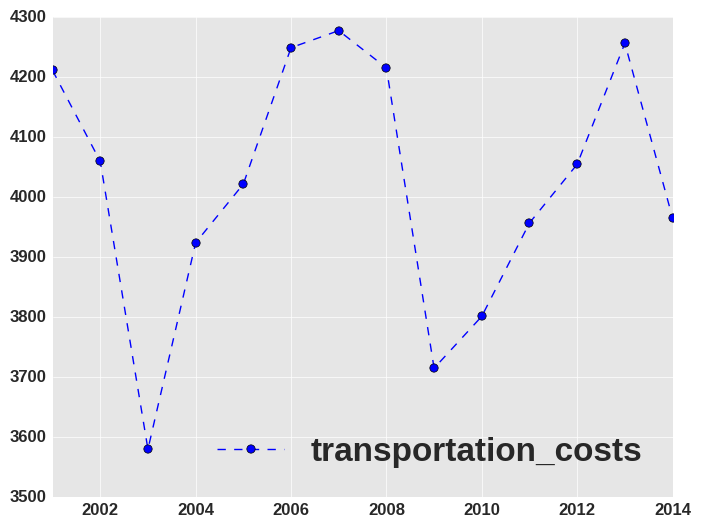

In [652]:
l = transportation_costs_df.transpose().plot(linestyle='--', marker='o')

## Health Care Costs Data Table

The model definition is specified in [Model Variable: Health Care Costs](#Health-Care-Costs).

In [526]:
health_costs_df

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
health_costs,1932.71496,2012.318321,2006.776085,2136.603659,2128.872392,2158.14434,2046.496085,2003.91239,2228.358321,2209.464019,2229.735367,2419.270384,2417.518513,2528.386391


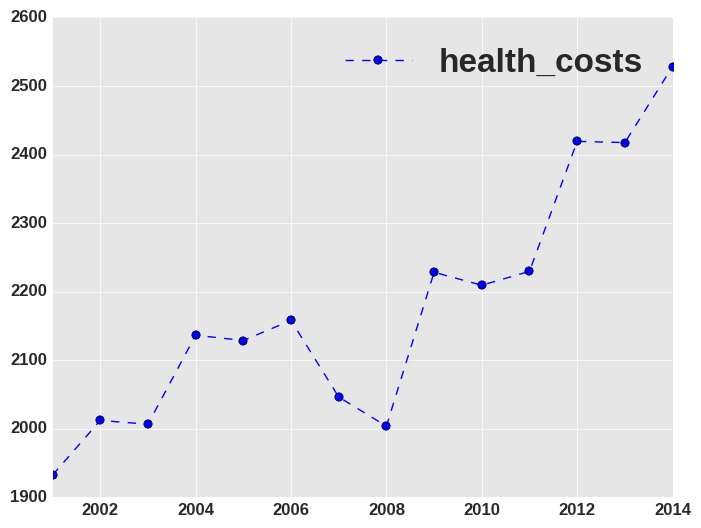

In [654]:
l = health_costs_df.transpose().plot(linestyle='--', marker='o')

## Other Necessities Cost Data Table

The model definition is specified in [Model Variable: Other Necessities Cost](#Other-Necessities-Cost)

In [528]:
other_costs_df

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
other_costs,2672.458026,2873.691516,2492.637841,2800.961068,2763.890813,2790.161546,2595.236769,2522.705462,2561.350255,2536.679344,2509.044763,2325.19951,2159.887757,2195.290565


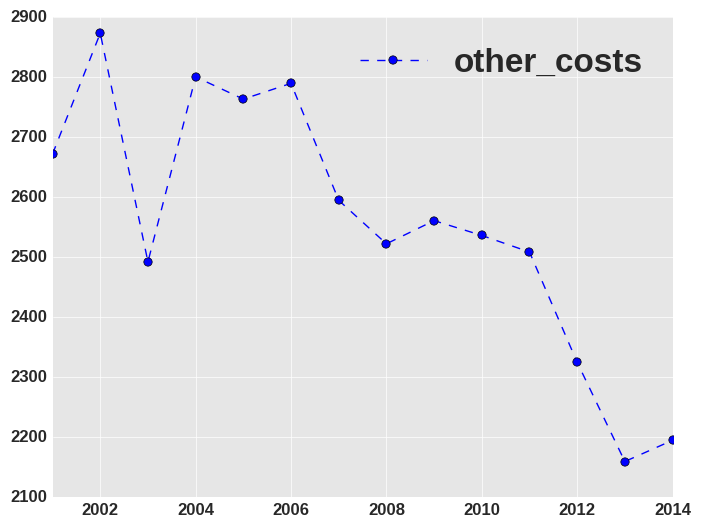

In [656]:
l = other_costs_df.transpose().plot(linestyle='--', marker='o')

## Appendix - Things to Revisit 

([TOC](#Table-of-Contents))

* Go back and redo CEX data to do proper regional weighting
* Make sure all inflation adjustments are done and done correctly
* Make sure understanding of CEX survey is solid and assignment of year is correct
* Education is not taken into account; which makes sense, but an expanded model of a 'middle class wage' might also be instructive
* Figure out the childcare costs for 2004 - 2005 and expand model into other family types outside of single adult